In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss
import torch
import torch.nn as nn
from tqdm import tqdm
import random
import copy
import inspect
import pandas as pd
import matplotlib.pyplot as plt

import data_interface
import mnar_blackout_lds

random.seed(42)
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Load the data
x_t, m_t, meta = data_interface.load_panel()

In [4]:
evaluation_windows = data_interface.get_eval_windows(
    data_dir="data",
)

In [5]:
from collections import defaultdict

def stratified_month_sampling(data, n_per_month, ts_key="blackout_start"):
    buckets = defaultdict(list)

    for item in data:
        ts = item[ts_key]
        month_key = (ts.year, ts.month)
        buckets[month_key].append(item)

    result = []
    for month_key, items in buckets.items():
        if len(items) < n_per_month:
            picks = random.choices(items, k=n_per_month)
        else:
            picks = random.sample(items, n_per_month)
        result.extend(picks)

    return result

In [6]:
# ------------------------------------------------------------------
# 1) Group evaluation windows by window_id and test_type/horizon
#    (handles cases where there are multiple rows per window_id).
# ------------------------------------------------------------------
impute_by_id = {}
forecast_1_by_id = {}
forecast_3_by_id = {}
forecast_6_by_id = {}

for w in evaluation_windows:
    wid = w["window_id"]
    if w["test_type"] == "impute":
        # If duplicates exist, last one wins – that's fine for eval.
        impute_by_id[wid] = w
    elif w["test_type"] == "forecast":
        h = int(w["horizon_steps"])
        if h == 1:
            forecast_1_by_id[wid] = w
        elif h == 3:
            forecast_3_by_id[wid] = w
        elif h == 6:
            forecast_6_by_id[wid] = w

In [7]:
# ------------------------------------------------------------------
# 2) Keep only window_ids that have impute + 1-step + 3-step + 6-step
# ------------------------------------------------------------------
common_ids = (
    set(impute_by_id.keys())
    & set(forecast_1_by_id.keys())
    & set(forecast_3_by_id.keys())
    & set(forecast_6_by_id.keys())
)

# Pool of impute windows that have all matching forecast horizons
impute_windows_pool = [impute_by_id[wid] for wid in common_ids]

In [8]:
# ------------------------------------------------------------------
# 3) Sample *validation* impute windows (stratified by month)
# ------------------------------------------------------------------
impute_evaluation_windows_val = stratified_month_sampling(
    impute_windows_pool,
    n_per_month=25,
    ts_key="blackout_start",
)

# Preserve order: we now build *aligned* forecast lists
val_ids_ordered = [w["window_id"] for w in impute_evaluation_windows_val]

forecast_1_evaluation_windows_val = [
    forecast_1_by_id[wid] for wid in val_ids_ordered
]
forecast_3_evaluation_windows_val = [
    forecast_3_by_id[wid] for wid in val_ids_ordered
]
forecast_6_evaluation_windows_val = [
    forecast_6_by_id[wid] for wid in val_ids_ordered
]

In [9]:
assert len(forecast_1_evaluation_windows_val) == len(impute_evaluation_windows_val)
assert len(forecast_3_evaluation_windows_val) == len(impute_evaluation_windows_val)
assert len(forecast_6_evaluation_windows_val) == len(impute_evaluation_windows_val)

# ------------------------------------------------------------------
# 4) Combined list used only for masking (deduped later)
# ------------------------------------------------------------------
evaluation_windows_val = (
    forecast_1_evaluation_windows_val
    + forecast_3_evaluation_windows_val
    + forecast_6_evaluation_windows_val
    + impute_evaluation_windows_val
)

In [10]:
# Time features for MNAR (T, F_time)
X_time = data_interface.build_time_features(meta["timestamps"])

#  detector-level features (D, F_det)
detector_features = None
try:
    Phi, feat_meta = data_interface.load_missingness_features("data")
    if "time_features" in feat_meta:
        X_time = feat_meta["time_features"]
    detector_features = feat_meta.get("detector_features", None)
except Exception:
    pass

In [11]:
def locf_impute_baseline(x_t, start_idx, end_idx, detector_idx):
    """
    Naive 'last observation carried forward' baseline for imputation.
    Uses the last finite value before blackout; falls back to
    detector-wise historical mean if needed.
    """
    last_idx = start_idx - 1
    while last_idx >= 0 and not np.isfinite(x_t[last_idx, detector_idx]):
        last_idx -= 1

    if last_idx < 0:
        det_vals = x_t[:, detector_idx]
        last_val = float(np.nanmean(det_vals))
    else:
        last_val = float(x_t[last_idx, detector_idx])

    length = end_idx - start_idx + 1
    return np.full(length, last_val, dtype=float)


def locf_forecast_baseline(x_t, end_idx, detector_idx):
    """
    Naive baseline for forecasting: hold the last available observation
    at the end of the blackout.
    """
    last_idx = end_idx
    while last_idx >= 0 and not np.isfinite(x_t[last_idx, detector_idx]):
        last_idx -= 1

    if last_idx < 0:
        det_vals = x_t[:, detector_idx]
        last_val = float(np.nanmean(det_vals))
    else:
        last_val = float(x_t[last_idx, detector_idx])

    return last_val


def evaluate_impute_forecast_model(
    model,
    mu_smooth,
    Sigma_smooth,
    mu_filt,
    Sigma_filt,
    x_t,
    meta,
    label="model",
    impute_windows=None,
    forecast_windows=None,
):
    """
    Re-usable evaluation for any LDS-like model (MAR or MNAR):
    - blackout imputation RMSE/MAE (length-weighted)
    - 1 / 3 / 6-step forecast RMSE/MAE
    """
    # ---------------- Imputation ----------------
    impute_mae_list = []
    impute_mse_list = []

    if impute_windows is None:
        impute_windows = impute_evaluation_windows_val

    for window in impute_windows:
        if window["test_type"] != "impute":
            continue

        start_idx = np.where(meta["timestamps"] == window["blackout_start"])[0][0]
        end_idx = np.where(meta["timestamps"] == window["blackout_end"])[0][0]
        detector_idx = np.where(meta["detectors"] == window["detector_id"])[0][0]

        eval_x_t = x_t[start_idx : end_idx + 1].copy()
        eval_mu_smooth = mu_smooth[start_idx : end_idx + 1]
        eval_Sigma_smooth = Sigma_smooth[start_idx : end_idx + 1]

        reconstruct_x_t, _ = model.reconstruct_from_smoother(
            eval_mu_smooth, eval_Sigma_smooth
        )

        y_true = eval_x_t[:, detector_idx]
        y_pred = reconstruct_x_t[:, detector_idx]

        mask = np.isfinite(y_true) & np.isfinite(y_pred)
        if not mask.any():
            continue

        mae = sklearn.metrics.mean_absolute_error(y_pred[mask], y_true[mask])
        mse = sklearn.metrics.mean_squared_error(y_pred[mask], y_true[mask])

        impute_mae_list.append([mae, window["len_steps"]])
        impute_mse_list.append([mse, window["len_steps"]])

    final_mae = np.average(
        [item[0] for item in impute_mae_list],
        weights=[item[1] for item in impute_mae_list],
    )
    final_mse = np.average(
        [item[0] for item in impute_mse_list],
        weights=[item[1] for item in impute_mse_list],
    )
    final_rmse = np.sqrt(final_mse)

    print(f"\n[{label}] Imputation performance:")
    print("  MAE :", final_mae)
    print("  MSE :", final_mse)
    print("  RMSE:", final_rmse)

    # ---------------- Forecasting ----------------
    y_actual_1_step, y_forecast_1_step = [], []
    y_actual_3_step, y_forecast_3_step = [], []
    y_actual_6_step, y_forecast_6_step = [], []

    if forecast_windows is None:
        forecast_windows = (
            forecast_1_evaluation_windows_val
            + forecast_3_evaluation_windows_val
            + forecast_6_evaluation_windows_val
        )

    for window in forecast_windows:
        if window["test_type"] != "forecast":
            continue

        start_idx = np.where(meta["timestamps"] == window["blackout_start"])[0][0]
        end_idx = np.where(meta["timestamps"] == window["blackout_end"])[0][0]
        detector_idx = np.where(meta["detectors"] == window["detector_id"])[0][0]
        horizon = int(window["horizon_steps"])

        # Skip windows too close to the end of the series
        if end_idx + horizon >= x_t.shape[0]:
            continue

        eval_x_t = x_t[end_idx + 1 : end_idx + 1 + horizon].copy()

        forecast_x_t, _ = model.k_step_forecast(
            mu_filt, Sigma_filt, end_idx, k=horizon
        )

        y_true = eval_x_t[horizon - 1, detector_idx]
        y_pred = forecast_x_t[detector_idx]

        if not (np.isfinite(y_true) and np.isfinite(y_pred)):
            continue

        if horizon == 1:
            y_forecast_1_step.append(y_pred)
            y_actual_1_step.append(y_true)
        elif horizon == 3:
            y_forecast_3_step.append(y_pred)
            y_actual_3_step.append(y_true)
        elif horizon == 6:
            y_forecast_6_step.append(y_pred)
            y_actual_6_step.append(y_true)

    mae_1_step = sklearn.metrics.mean_absolute_error(
        y_forecast_1_step, y_actual_1_step
    )
    mse_1_step = sklearn.metrics.mean_squared_error(
        y_forecast_1_step, y_actual_1_step
    )
    rmse_1_step = np.sqrt(mse_1_step)

    mae_3_step = sklearn.metrics.mean_absolute_error(
        y_forecast_3_step, y_actual_3_step
    )
    mse_3_step = sklearn.metrics.mean_squared_error(
        y_forecast_3_step, y_actual_3_step
    )
    rmse_3_step = np.sqrt(mse_3_step)

    mae_6_step = sklearn.metrics.mean_absolute_error(
        y_forecast_6_step, y_actual_6_step
    )
    mse_6_step = sklearn.metrics.mean_squared_error(
        y_forecast_6_step, y_actual_6_step
    )
    rmse_6_step = np.sqrt(mse_6_step)

    print(f"\n[{label}] Forecasting performance:")
    print("-----------------------------------")
    print("1-step MAE :", mae_1_step)
    print("1-step MSE :", mse_1_step)
    print("1-step RMSE:", rmse_1_step)

    print("\n-----------------------------------")
    print("3-step MAE :", mae_3_step)
    print("3-step MSE :", mse_3_step)
    print("3-step RMSE:", rmse_3_step)

    print("\n-----------------------------------")
    print("6-step MAE :", mae_6_step)
    print("6-step MSE :", mse_6_step)
    print("6-step RMSE:", rmse_6_step)

    return {
        "impute_mae": final_mae,
        "impute_mse": final_mse,
        "impute_rmse": final_rmse,
        "forecast_mae_1": mae_1_step,
        "forecast_mse_1": mse_1_step,
        "forecast_rmse_1": rmse_1_step,
        "forecast_mae_3": mae_3_step,
        "forecast_mse_3": mse_3_step,
        "forecast_rmse_3": rmse_3_step,
        "forecast_mae_6": mae_6_step,
        "forecast_mse_6": mse_6_step,
        "forecast_rmse_6": rmse_6_step,
    }

In [12]:
# ============================================================
# 1) Stronger baselines
#    - Linear interpolation inside blackout (uses pre + post points)
#    - Optional spline interpolation (falls back to linear)
#    - Seasonal naive for forecasting (same time yesterday / last week)
# ============================================================
def _find_last_finite(x: np.ndarray, idx: int, d: int) -> tuple[int, float] | tuple[None, None]:
    j = idx
    while j >= 0 and not np.isfinite(x[j, d]):
        j -= 1
    if j < 0:
        return None, None
    return j, float(x[j, d])


def _find_next_finite(x: np.ndarray, idx: int, d: int) -> tuple[int, float] | tuple[None, None]:
    j = idx
    T = x.shape[0]
    while j < T and not np.isfinite(x[j, d]):
        j += 1
    if j >= T:
        return None, None
    return j, float(x[j, d])


def linear_interp_impute_baseline(x_t_masked, start_idx, end_idx, detector_idx):
    """
    Impute a blackout [start_idx, end_idx] by linear interpolation between:
      left  = last finite before start
      right = first finite after end
    Falls back to LOCF if one side missing.
    """
    left_j, left_v = _find_last_finite(x_t_masked, start_idx - 1, detector_idx)
    right_j, right_v = _find_next_finite(x_t_masked, end_idx + 1, detector_idx)

    L = end_idx - start_idx + 1
    if left_v is None and right_v is None:
        # ultimate fallback: detector mean
        det_vals = x_t_masked[:, detector_idx]
        fill = float(np.nanmean(det_vals))
        return np.full(L, fill, dtype=float)
    if left_v is None:
        return np.full(L, right_v, dtype=float)
    if right_v is None:
        return np.full(L, left_v, dtype=float)

    # interpolate over actual index distance so long gaps are handled correctly
    xs = np.arange(start_idx, end_idx + 1)
    denom = max((right_j - left_j), 1)
    alpha = (xs - left_j) / denom
    return (1 - alpha) * left_v + alpha * right_v


def spline_impute_baseline(
    x_t_masked, start_idx, end_idx, detector_idx,
    order=3, context=288  # 1 day on 5-min grid
):
    """
    Local spline interpolation around the blackout only.
    Falls back to linear if spline fails or insufficient support.
    """
    try:
        T = x_t_masked.shape[0]
        a = max(0, start_idx - context)
        b = min(T, end_idx + context + 1)

        s = pd.Series(x_t_masked[a:b, detector_idx]).astype(float)

        # blackout region relative to the local slice
        s_rel = start_idx - a
        e_rel = end_idx - a
        s.iloc[s_rel:e_rel+1] = np.nan

        s = s.interpolate(method="spline", order=order, limit_direction="both")

        return s.iloc[s_rel:e_rel+1].to_numpy(dtype=float)
    except Exception:
        return linear_interp_impute_baseline(x_t_masked, start_idx, end_idx, detector_idx)


def seasonal_naive_forecast_baseline(x_t_masked, target_idx, detector_idx, offsets=(288, 2016)):
    """
    Forecast x[target_idx, d] using historical seasonal offsets:
      - 288 steps = 1 day back (5-min grid)
      - 2016 steps = 1 week back
    Falls back to LOCF at end of blackout if needed.
    """
    for off in offsets:
        j = target_idx - off
        if j >= 0 and np.isfinite(x_t_masked[j, detector_idx]):
            return float(x_t_masked[j, detector_idx])
    # fallback: last observed before target
    j, v = _find_last_finite(x_t_masked, target_idx - 1, detector_idx)
    if v is None:
        det_vals = x_t_masked[:, detector_idx]
        return float(np.nanmean(det_vals))
    return v

def build_hour_of_week_climatology(
    x_t_masked: np.ndarray,
    m_t_masked: np.ndarray,
    timestamps: np.ndarray,
    step_minutes: int = 5,
):
    """
    Builds time-of-week climatology: mean per (slot_of_week, detector).

    slot_of_week = dow * steps_per_day + step_in_day
    where step_in_day = (hour*60 + minute) // step_minutes

    Returns:
      how_mean: (S, D) array of means, S = 7 * steps_per_day
      slot_of_week: (T,) int array mapping each t -> slot index
      global_mean: (D,) detector-wise global mean fallback
    """
    ts = pd.to_datetime(timestamps)
    dow = ts.dayofweek.to_numpy()  # Mon=0
    minutes = (ts.hour.to_numpy() * 60 + ts.minute.to_numpy())

    steps_per_day = int((24 * 60) // step_minutes)
    step_in_day = (minutes // step_minutes).astype(int)
    # safety: if timestamps aren't aligned to step_minutes, clamp
    step_in_day = np.clip(step_in_day, 0, steps_per_day - 1)

    slot_of_week = (dow * steps_per_day + step_in_day).astype(int)
    S = 7 * steps_per_day
    T, D = x_t_masked.shape

    # observed mask: 1 where observed & finite
    obs = (m_t_masked == 0) & np.isfinite(x_t_masked)

    # detector-wise global mean fallback (computed only from observed)
    global_mean = np.nan_to_num(
        (np.nansum(np.where(obs, x_t_masked, 0.0), axis=0) / (obs.sum(axis=0) + 1e-6)),
        nan=0.0
    ).astype(float)

    sums = np.zeros((S, D), dtype=np.float64)
    cnts = np.zeros((S, D), dtype=np.float64)

    # single pass over time; vectorized over detectors
    for t in range(T):
        s = slot_of_week[t]
        m = obs[t]  # (D,)
        if not m.any():
            continue
        sums[s, m] += x_t_masked[t, m]
        cnts[s, m] += 1.0

    how_mean = sums / np.maximum(cnts, 1.0)
    how_mean[cnts < 1.0] = np.nan  # mark unseen slots as nan
    return how_mean.astype(float), slot_of_week, global_mean


def make_hour_of_week_forecast_fn(how_mean, slot_of_week, global_mean):
    """
    Returns a forecast_fn compatible with evaluate_impute_forecast_baseline:
      forecast_fn(x_t_masked, target_idx, detector_idx) -> float
    """
    def _fn(x_t_masked, target_idx, detector_idx):
        s = int(slot_of_week[target_idx])
        mu = how_mean[s, detector_idx]
        if np.isfinite(mu):
            return float(mu)
        # fallback: detector global mean, then LOCF
        gm = global_mean[detector_idx]
        if np.isfinite(gm):
            return float(gm)
        j, v = _find_last_finite(x_t_masked, target_idx - 1, detector_idx)
        if v is None:
            return 0.0
        return float(v)
    return _fn


def evaluate_impute_forecast_baseline(
    x_t_true,
    x_t_masked,
    meta,
    impute_fn,
    forecast_fn,
    label="baseline",
):
    """
    Generic evaluator for baselines.
      impute_fn(x_t_masked, start_idx, end_idx, detector_idx) -> (L,)
      forecast_fn(x_t_masked, target_idx, detector_idx) -> float
    """
    # ---------- Imputation ----------
    impute_mae_list = []
    impute_mse_list = []

    for window in impute_evaluation_windows_val:
        start_idx = np.where(meta["timestamps"] == window["blackout_start"])[0][0]
        end_idx   = np.where(meta["timestamps"] == window["blackout_end"])[0][0]
        d         = np.where(meta["detectors"] == window["detector_id"])[0][0]

        y_true = x_t_true[start_idx:end_idx+1, d].copy()
        y_pred = impute_fn(x_t_masked, start_idx, end_idx, d)

        mask = np.isfinite(y_true) & np.isfinite(y_pred)
        if not mask.any():
            continue

        mae = sklearn.metrics.mean_absolute_error(y_pred[mask], y_true[mask])
        mse = sklearn.metrics.mean_squared_error(y_pred[mask], y_true[mask])
        impute_mae_list.append([mae, window["len_steps"]])
        impute_mse_list.append([mse, window["len_steps"]])

    final_mae = np.average([a for a,_ in impute_mae_list], weights=[w for _,w in impute_mae_list])
    final_mse = np.average([a for a,_ in impute_mse_list], weights=[w for _,w in impute_mse_list])
    final_rmse = float(np.sqrt(final_mse))

    print(f"\n[{label}] Imputation performance:")
    print("  MAE :", final_mae)
    print("  MSE :", final_mse)
    print("  RMSE:", final_rmse)

    # ---------- Forecast ----------
    y_true_1, y_pred_1 = [], []
    y_true_3, y_pred_3 = [], []
    y_true_6, y_pred_6 = [], []

    forecast_windows = (
        forecast_1_evaluation_windows_val
        + forecast_3_evaluation_windows_val
        + forecast_6_evaluation_windows_val
    )

    for window in forecast_windows:
        end_idx = np.where(meta["timestamps"] == window["blackout_end"])[0][0]
        d       = np.where(meta["detectors"] == window["detector_id"])[0][0]
        h       = int(window["horizon_steps"])
        target_idx = end_idx + h
        if target_idx >= x_t_true.shape[0]:
            continue

        yt = x_t_true[target_idx, d]
        yp = forecast_fn(x_t_masked, target_idx, d)
        if not (np.isfinite(yt) and np.isfinite(yp)):
            continue

        if h == 1:
            y_true_1.append(yt); y_pred_1.append(yp)
        elif h == 3:
            y_true_3.append(yt); y_pred_3.append(yp)
        elif h == 6:
            y_true_6.append(yt); y_pred_6.append(yp)

    def _pack(y_pred, y_true, h):
        mae = sklearn.metrics.mean_absolute_error(y_pred, y_true)
        mse = sklearn.metrics.mean_squared_error(y_pred, y_true)
        rmse = float(np.sqrt(mse))
        print(f"{h}-step MAE :", mae)
        print(f"{h}-step MSE :", mse)
        print(f"{h}-step RMSE:", rmse)
        return mae, mse, rmse

    print(f"\n[{label}] Forecasting performance:")
    print("-----------------------------------")
    mae1,mse1,rmse1 = _pack(y_pred_1, y_true_1, 1)
    print("\n-----------------------------------")
    mae3,mse3,rmse3 = _pack(y_pred_3, y_true_3, 3)
    print("\n-----------------------------------")
    mae6,mse6,rmse6 = _pack(y_pred_6, y_true_6, 6)

    return {
        "impute_mae": final_mae,
        "impute_mse": final_mse,
        "impute_rmse": final_rmse,
        "forecast_mae_1": mae1, "forecast_mse_1": mse1, "forecast_rmse_1": rmse1,
        "forecast_mae_3": mae3, "forecast_mse_3": mse3, "forecast_rmse_3": rmse3,
        "forecast_mae_6": mae6, "forecast_mse_6": mse6, "forecast_rmse_6": rmse6,
    }

In [13]:
def evaluate_locf_baseline(
    x_t_true,
    x_t_masked,
    meta,
    label="LOCF baseline",
):
    """
    Baseline evaluation using LOCF for both imputation and forecasting.
    x_t_true   : full panel (no artificial masking), used ONLY for y_true
    x_t_masked : panel with blackout windows masked (same as training),
                 used for baseline predictions so it can't peek inside.
    """
    # ---------- Imputation ----------
    impute_mae_list = []
    impute_mse_list = []

    for window in impute_evaluation_windows_val:
        if window["test_type"] != "impute":
            continue

        start_idx = np.where(meta["timestamps"] == window["blackout_start"])[0][0]
        end_idx   = np.where(meta["timestamps"] == window["blackout_end"])[0][0]
        detector_idx = np.where(meta["detectors"] == window["detector_id"])[0][0]

        # Truth from full data
        y_true = x_t_true[start_idx : end_idx + 1, detector_idx].copy()

        # LOCF baseline only sees masked training panel
        y_pred = locf_impute_baseline(
            x_t_masked, start_idx, end_idx, detector_idx
        )

        mask = np.isfinite(y_true) & np.isfinite(y_pred)
        if not mask.any():
            continue

        mae = sklearn.metrics.mean_absolute_error(y_pred[mask], y_true[mask])
        mse = sklearn.metrics.mean_squared_error(y_pred[mask], y_true[mask])

        impute_mae_list.append([mae, window["len_steps"]])
        impute_mse_list.append([mse, window["len_steps"]])

    final_mae = np.average(
        [item[0] for item in impute_mae_list],
        weights=[item[1] for item in impute_mae_list],
    )
    final_mse = np.average(
        [item[0] for item in impute_mse_list],
        weights=[item[1] for item in impute_mse_list],
    )
    final_rmse = np.sqrt(final_mse)

    print(f"\n[{label}] Imputation performance:")
    print("  MAE :", final_mae)
    print("  MSE :", final_mse)
    print("  RMSE:", final_rmse)

    # ---------- Forecast ----------
    y_actual_1_step, y_forecast_1_step = [], []
    y_actual_3_step, y_forecast_3_step = [], []
    y_actual_6_step, y_forecast_6_step = [], []

    forecast_evaluation_windows_val = (
        forecast_1_evaluation_windows_val
        + forecast_3_evaluation_windows_val
        + forecast_6_evaluation_windows_val
    )

    for window in forecast_evaluation_windows_val:
        if window["test_type"] != "forecast":
            continue

        start_idx = np.where(meta["timestamps"] == window["blackout_start"])[0][0]
        end_idx   = np.where(meta["timestamps"] == window["blackout_end"])[0][0]
        detector_idx = np.where(meta["detectors"] == window["detector_id"])[0][0]
        horizon = int(window["horizon_steps"])

        if end_idx + horizon >= x_t_true.shape[0]:
            continue

        # Truth from full data
        y_true = x_t_true[end_idx + horizon, detector_idx]

        # Baseline sees ONLY masked panel (so it uses last observed pre-blackout)
        y_pred = locf_forecast_baseline(
            x_t_masked, end_idx, detector_idx
        )

        if not (np.isfinite(y_true) and np.isfinite(y_pred)):
            continue

        if horizon == 1:
            y_forecast_1_step.append(y_pred)
            y_actual_1_step.append(y_true)
        elif horizon == 3:
            y_forecast_3_step.append(y_pred)
            y_actual_3_step.append(y_true)
        elif horizon == 6:
            y_forecast_6_step.append(y_pred)
            y_actual_6_step.append(y_true)

    mae_1_step = sklearn.metrics.mean_absolute_error(
        y_forecast_1_step, y_actual_1_step
    )
    mse_1_step = sklearn.metrics.mean_squared_error(
        y_forecast_1_step, y_actual_1_step
    )
    rmse_1_step = np.sqrt(mse_1_step)

    mae_3_step = sklearn.metrics.mean_absolute_error(
        y_forecast_3_step, y_actual_3_step
    )
    mse_3_step = sklearn.metrics.mean_squared_error(
        y_forecast_3_step, y_actual_3_step
    )
    rmse_3_step = np.sqrt(mse_3_step)

    mae_6_step = sklearn.metrics.mean_absolute_error(
        y_forecast_6_step, y_actual_6_step
    )
    mse_6_step = sklearn.metrics.mean_squared_error(
        y_forecast_6_step, y_actual_6_step
    )
    rmse_6_step = np.sqrt(mse_6_step)

    print(f"\n[{label}] Forecasting performance:")
    print("-----------------------------------")
    print("1-step MAE :", mae_1_step)
    print("1-step MSE :", mse_1_step)
    print("1-step RMSE:", rmse_1_step)

    print("\n-----------------------------------")
    print("3-step MAE :", mae_3_step)
    print("3-step MSE :", mse_3_step)
    print("3-step RMSE:", rmse_3_step)

    print("\n-----------------------------------")
    print("6-step MAE :", mae_6_step)
    print("6-step MSE :", mse_6_step)
    print("6-step RMSE:", rmse_6_step)

    return {
        "impute_mae": final_mae,
        "impute_mse": final_mse,
        "impute_rmse": final_rmse,
        "forecast_mae_1": mae_1_step,
        "forecast_mse_1": mse_1_step,
        "forecast_rmse_1": rmse_1_step,
        "forecast_mae_3": mae_3_step,
        "forecast_mse_3": mse_3_step,
        "forecast_rmse_3": rmse_3_step,
        "forecast_mae_6": mae_6_step,
        "forecast_mse_6": mse_6_step,
        "forecast_rmse_6": rmse_6_step,
    }

In [14]:
def mask_evaluation_windows(x_t, m_t, evaluation_windows_val, meta):
    x_t_masked = x_t.copy()
    m_t_masked = m_t.copy()

    # a_t = 1 where we artificially mask for evaluation (NOT "real" missingness)
    a_t = np.zeros_like(m_t_masked, dtype=np.uint8)

    # Deduplicate (detector, start, end) so we don't re-mask the same block many times
    unique_blocks = set()
    for window in evaluation_windows_val:
        start_ts = window["blackout_start"]
        end_ts = window["blackout_end"]
        det_id = window["detector_id"]
        unique_blocks.add((start_ts, end_ts, det_id))

    for (start_ts, end_ts, det_id) in unique_blocks:
        start_idx = np.where(meta["timestamps"] == start_ts)[0][0]
        end_idx = np.where(meta["timestamps"] == end_ts)[0][0]
        detector_idx = np.where(meta["detectors"] == det_id)[0][0]

        x_t_masked[start_idx:end_idx+1, detector_idx] = np.nan
        m_t_masked[start_idx:end_idx+1, detector_idx] = 1
        a_t[start_idx:end_idx+1, detector_idx] = 1

    return x_t_masked, m_t_masked, a_t

In [15]:
# Prepare training data by masking evaluation windows
x_t_train, m_t_train, a_t_train = mask_evaluation_windows(x_t, m_t, evaluation_windows_val, meta)
latent_dim = 20
D = x_t_train.shape[1]

In [16]:
# ---------------- MAR model (no phi updates) ----------------
mar_params = mnar_blackout_lds.MNARParams.init_random(K=latent_dim, D=D, seed=42)
model_mar = mnar_blackout_lds.MNARBlackoutLDS(
    mar_params,
    use_missingness_obs=False,   # IMPORTANT: true MAR ignores masks in inference
)
em_train_history_mar = model_mar.em_train(
    x_t_train,
    m_t_train,
    num_iters=10,
    update_phi=False,  # MAR: ignore missingness mechanism
    phi_steps=0,
    phi_lr=0.0,
    verbose=True,
    convergence_tol=1e-3,
    use_missingness_obs=False,   # IMPORTANT: E-step ignores masks
)

# ---------------- MNAR model (warm-start from MAR) ----------------
 # NOTE: Deep-copy the *trained* MAR params so MNAR starts from a good LDS fit.
 # This is especially helpful when running a small number of EM iterations.
mnar_params = copy.deepcopy(model_mar.params)
 
 # MAR never learned phi; initialize phi safely for MNAR.
 # start at 0 => p(missing)=0.5 everywhere, then learn signal.
if hasattr(mnar_params, "phi") and (mnar_params.phi is not None):
    mnar_params.phi[:] = 0.0
if hasattr(mnar_params, "phi_time") and (mnar_params.phi_time is not None) and (mnar_params.phi_time.size > 0):
    mnar_params.phi_time[:] = 0.0
if hasattr(mnar_params, "phi_det") and (mnar_params.phi_det is not None) and (mnar_params.phi_det.size > 0):
    mnar_params.phi_det[:] = 0.0
if hasattr(mnar_params, "bias_m") and (mnar_params.bias_m is not None):
    mnar_params.bias_m[:] = 0.0   
 
model_mnar = mnar_blackout_lds.MNARBlackoutLDS(
    mnar_params,
    use_missingness_obs=True,
    missingness_var_mode="moment",   # default; used for main MNAR run
    missingness_var_const=0.25,      # used for ablation if needed
)
em_train_history_mnar = model_mnar.em_train(
    x_t_train,
    m_t_train,
    num_iters=10,
    update_phi=True,   # MNAR: learn missingness mechanism
    phi_steps=2,
    phi_lr=1e-4,
    verbose=True,
    convergence_tol=1e-3,
    use_missingness_obs=True,
    init_missingness_bias=True,   
    init_phi_if_zero=True,
    init_phi_noise=1e-3,
    init_seed=0,
)


=== EM iteration 1/10 ===
  A norm: 4.345
  Q trace: 8.298
  mean diag(R): 37.242

=== EM iteration 2/10 ===
  A norm: 4.209
  Q trace: 30.000
  mean diag(R): 21.885
  max relative param change: 2.419e-01

=== EM iteration 3/10 ===
  A norm: 4.217
  Q trace: 30.000
  mean diag(R): 19.582
  max relative param change: 1.129e-01

=== EM iteration 4/10 ===
  A norm: 4.258
  Q trace: 30.000
  mean diag(R): 19.079
  max relative param change: 7.745e-02

=== EM iteration 5/10 ===
  A norm: 4.275
  Q trace: 30.000
  mean diag(R): 18.883
  max relative param change: 5.694e-02

=== EM iteration 6/10 ===
  A norm: 4.281
  Q trace: 30.000
  mean diag(R): 18.789
  max relative param change: 4.028e-02

=== EM iteration 7/10 ===
  A norm: 4.283
  Q trace: 30.000
  mean diag(R): 18.747
  max relative param change: 3.031e-02

=== EM iteration 8/10 ===
  A norm: 4.284
  Q trace: 30.000
  mean diag(R): 18.730
  max relative param change: 2.482e-02

=== EM iteration 9/10 ===
  A norm: 4.284
  Q trace: 30

### Reconstruction and Prediction

In [17]:
ekf_mar = model_mar.ekf_forward(x_t_train, m_t_train)
smoother_mar = model_mar.rts_smoother(ekf_mar)

mu_filt_mar = ekf_mar["mu_filt"]
Sigma_filt_mar = ekf_mar["Sigma_filt"]
mu_smooth_mar = smoother_mar["mu_smooth"]
Sigma_smooth_mar = smoother_mar["Sigma_smooth"]

metrics_mar = evaluate_impute_forecast_model(
    model=model_mar,
    mu_smooth=mu_smooth_mar,
    Sigma_smooth=Sigma_smooth_mar,
    mu_filt=mu_filt_mar,
    Sigma_filt=Sigma_filt_mar,
    x_t=x_t,
    meta=meta,
    label="MAR LDS",
)


[MAR LDS] Imputation performance:
  MAE : 2.847129794455783
  MSE : 17.882877411173496
  RMSE: 4.228815130881639

[MAR LDS] Forecasting performance:
-----------------------------------
1-step MAE : 3.102171557957012
1-step MSE : 19.28242521384097
1-step RMSE: 4.391175834994651

-----------------------------------
3-step MAE : 3.1254790564160118
3-step MSE : 18.916878095856397
3-step RMSE: 4.349353756117844

-----------------------------------
6-step MAE : 3.4332839591033615
6-step MSE : 26.62479192488619
6-step RMSE: 5.159921697553771


In [ ]:
# ============================================================
# 2) Missingness diagnosis (Tests 1–3)
# ============================================================
def build_blackout_onset_dataset(windows, x_t_true, m_t_true, meta, X_time, past_steps=12):
    """
    Build (X, y) where each sample is a blackout ONSET edge:
      time t0 = start_idx-1 (last observed before blackout)
      label y = m[t0+1, d] (should be 1 for true onsets)
    Features (observed-only):
      - last observed speed at t0
      - rolling variance over past_steps (default 1 hour = 12*5min)
      - time features at t0
    Returns:
      X_obs: (N, 2+F_time)
      y:     (N,)
      t0_idx: (N,)
      d_idx:  (N,)
    """
    X_list, y_list, t0_list, d_list = [], [], [], []
    for w in windows:
        start_idx = np.where(meta["timestamps"] == w["blackout_start"])[0][0]
        d = np.where(meta["detectors"] == w["detector_id"])[0][0]
        t0 = start_idx - 1
        if t0 <= past_steps or t0 + 1 >= x_t_true.shape[0]:
            continue
        last_speed = x_t_true[t0, d]
        if not np.isfinite(last_speed):
            continue
        hist = x_t_true[t0-past_steps:t0, d]
        hist = hist[np.isfinite(hist)]
        if hist.size < max(3, past_steps//3):
            continue
        roll_var = float(np.var(hist))
        feats = np.concatenate([[last_speed, roll_var], X_time[t0]], axis=0)
        y = float(m_t_true[t0+1, d])  # whether next step is missing
        X_list.append(feats); y_list.append(y); t0_list.append(t0); d_list.append(d)
    return np.asarray(X_list, float), np.asarray(y_list, float), np.asarray(t0_list), np.asarray(d_list)


def build_matched_control_dataset(N, x_t_true, m_t_true, X_time, t0_idx, d_idx, rng=42):
    """
    Controls: sample (t,d) pairs with the SAME hour/weekend/rush distribution
    as onsets by sampling t from the same t0_idx pool, but with random detectors,
    and forcing label to be actual next-step missingness.
    """
    rs = np.random.default_rng(rng)
    Xc, yc = [], []
    T, D = x_t_true.shape
    for i in range(N):
        t0 = int(t0_idx[rs.integers(0, len(t0_idx))])
        d = int(rs.integers(0, D))
        if t0 <= 12 or t0 + 1 >= T:
            continue
        last_speed = x_t_true[t0, d]
        if not np.isfinite(last_speed):
            continue
        hist = x_t_true[t0-12:t0, d]
        hist = hist[np.isfinite(hist)]
        if hist.size < 4:
            continue
        roll_var = float(np.var(hist))
        feats = np.concatenate([[last_speed, roll_var], X_time[t0]], axis=0)
        y = float(m_t_true[t0+1, d])
        Xc.append(feats); yc.append(y)
    Xc = np.asarray(Xc, float)
    yc = np.asarray(yc, float)
    return Xc, yc


def auc_logreg(X, y, label="clf"):
    clf = LogisticRegression(max_iter=2000, class_weight="balanced")
    clf.fit(X, y)
    p = clf.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, p)
    print(f"[{label}] AUC = {auc:.4f}  (N={len(y)}, pos={y.mean():.3f})")
    return auc


# --- Test 1: observed-only proxies near blackout edges ---
X_on, y_on, t0_on, d_on = build_blackout_onset_dataset(
    impute_evaluation_windows_val, x_t, m_t, meta, X_time, past_steps=12
)
X_ctrl, y_ctrl = build_matched_control_dataset(len(y_on), x_t, m_t, X_time, t0_on, d_on, rng=42)

X1 = np.vstack([X_on, X_ctrl])
y1 = np.concatenate([np.ones(len(y_on)), np.zeros(len(y_ctrl))])  # onset vs control
auc_test1 = auc_logreg(X1, y1, label="Test1 (observed-only): onset vs control")


def build_nextstep_missingness_dataset_balanced(
    x_t_true, m_t_true, X_time, mu_smooth,
    sample_stride=12, max_pos=20_000, neg_per_pos=3, seed=0,
    ds_per_t=64,
):
    """
    Balanced next-step missingness dataset:
      y = 1 if m[t+1,d] is missing, using only observed x[t,d].
    Guarantees positives exist (otherwise raises) to avoid pos_rate=0.000.
    """
    rs = np.random.default_rng(seed)
    T, D = x_t_true.shape
    pos = []
    neg = []

    # Pass 1: collect positives (scan broadly until max_pos or end)
    for t in range(0, T - 2, sample_stride):
        ds = rs.integers(0, D, size=min(ds_per_t, D))
        for d in ds:
            if not np.isfinite(x_t_true[t, d]):
                continue
            y = int(m_t_true[t + 1, d] > 0)  # robust to bool/float
            if y != 1:
                continue
            feat_obs = np.concatenate([[x_t_true[t, d]], X_time[t]])
            feat_lat = np.concatenate([[x_t_true[t, d]], X_time[t], mu_smooth[t]])
            pos.append((t, feat_obs, feat_lat, 1))
            if len(pos) >= max_pos:
                break
        if len(pos) >= max_pos:
            break

    if len(pos) == 0:
        raise RuntimeError("No positive (missing) examples found. Check m_t encoding (1=missing?) or sampling.")

    # Pass 2: collect negatives matched in time distribution by sampling t from pos-times
    max_neg = int(neg_per_pos * len(pos))
    pos_t0 = np.asarray([t for (t, *_rest) in pos], dtype=int)
    while len(neg) < max_neg:
        t = int(pos_t0[rs.integers(0, len(pos_t0))])
        d = int(rs.integers(0, D))
        if t >= T - 2:
            continue
        if not np.isfinite(x_t_true[t, d]):
            continue
        y = int(m_t_true[t + 1, d] > 0)
        if y != 0:
            continue
        feat_obs = np.concatenate([[x_t_true[t, d]], X_time[t]])
        feat_lat = np.concatenate([[x_t_true[t, d]], X_time[t], mu_smooth[t]])
        neg.append((t, feat_obs, feat_lat, 0))

    data = pos + neg
    data.sort(key=lambda z: z[0])  # keep time ordering for time-aware split
    Xobs = np.asarray([a for _, a, _, _ in data], float)
    Xlat = np.asarray([b for _, _, b, _ in data], float)
    y    = np.asarray([c for *_x, c in data], int)
    return Xobs, Xlat, y


# ----------------------------
# Balanced Test2 (ROC-AUC + PR-AUC + LogLoss)
# ----------------------------
X2_obs, X2_lat, y2 = build_nextstep_missingness_dataset_balanced(
    x_t_true=x_t,
    m_t_true=m_t,
    X_time=X_time,
    mu_smooth=mu_smooth_mar,
    sample_stride=12,
    max_pos=20_000,
    neg_per_pos=3,
    seed=0,
)

print(f"[Test2 Balanced] N={len(y2)}  pos_rate={y2.mean():.3f}")

# Time-aware split: first 70% train, last 30% test (because we kept time order)
n = len(y2)
split = int(0.7 * n)

Xobs_tr, Xobs_te = X2_obs[:split], X2_obs[split:]
Xlat_tr, Xlat_te = X2_lat[:split], X2_lat[split:]
y_tr, y_te       = y2[:split], y2[split:]

clf_obs = LogisticRegression(max_iter=2000, n_jobs=-1, class_weight="balanced").fit(Xobs_tr, y_tr)
clf_lat = LogisticRegression(max_iter=2000, n_jobs=-1, class_weight="balanced").fit(Xlat_tr, y_tr)

for name, clf, Xte in [("OBS", clf_obs, Xobs_te), ("LAT", clf_lat, Xlat_te)]:
    p = clf.predict_proba(Xte)[:, 1]
    print(f"[{name}] ROC-AUC:", roc_auc_score(y_te, p))
    print(f"[{name}] PR-AUC :", average_precision_score(y_te, p))
    print(f"[{name}] LogLoss:", log_loss(y_te, p))



# --- Test 3: event-level clustering / structure ---
try:
    det_events = data_interface.load_detector_blackouts("data", as_dataframe=True)
    net_events = data_interface.load_network_blackouts("data", as_dataframe=True)

    print("\n[Test3] Detector blackout durations (steps) summary:")
    print(det_events["len_steps"].describe())
    print("\n[Test3] Network blackout durations (steps) summary:")
    print(net_events["len_steps"].describe())

    # Simple clustering proxy: inter-event time (network-level)
    net_starts = pd.to_datetime(net_events["start"]).sort_values()
    deltas_min = net_starts.diff().dropna().dt.total_seconds() / 60.0
    print("\n[Test3] Network inter-event time (minutes) summary:")
    print(deltas_min.describe())
except Exception as e:
    print(f"[Test3] Skipped (missing blackout event parquet?): {e}")

[Test1 (observed-only): onset vs control] AUC = 0.5332  (N=575, pos=0.515)
[Test2 Balanced] N=60015  pos_rate=0.000
[OBS] ROC-AUC: 0.6984643115208398
[OBS] PR-AUC : 0.0031538385866652164
[OBS] LogLoss: 0.008161198368216068
[LAT] ROC-AUC: 0.5070551148590168
[LAT] PR-AUC : 0.0008422826482461243
[LAT] LogLoss: 0.015001390778423078

[Test3] Detector blackout durations (steps) summary:
count      942.000000
mean       849.284501
std       7138.302338
min         12.000000
25%         18.000000
50%         37.000000
75%         84.000000
max      88536.000000
Name: len_steps, dtype: float64

[Test3] Network blackout durations (steps) summary:
count     25.00000
mean      66.92000
std       92.28214
min        2.00000
25%       19.00000
50%       36.00000
75%       84.00000
max      427.00000
Name: len_steps, dtype: float64

[Test3] Network inter-event time (minutes) summary:
count        24.000000
mean      18596.041667
std       28327.880873
min          20.000000
25%         748.750000
50%

In [19]:
# ---------------- Reconstruction & prediction: MNAR ----------------
ekf_mnar = model_mnar.ekf_forward(
    x_t_train,
    m_t_train,
    a_t=a_t_train, 
    X_time=X_time,
    detector_features=detector_features,
)
smoother_mnar = model_mnar.rts_smoother(ekf_mnar)

mu_filt_mnar = ekf_mnar["mu_filt"]
Sigma_filt_mnar = ekf_mnar["Sigma_filt"]
mu_smooth_mnar = smoother_mnar["mu_smooth"]
Sigma_smooth_mnar = smoother_mnar["Sigma_smooth"]

metrics_mnar = evaluate_impute_forecast_model(
    model=model_mnar,
    mu_smooth=mu_smooth_mnar,
    Sigma_smooth=Sigma_smooth_mnar,
    mu_filt=mu_filt_mnar,
    Sigma_filt=Sigma_filt_mnar,
    x_t=x_t,
    meta=meta,
    label="MNAR LDS (report: const missingness var)",
)


[MNAR LDS (report: const missingness var)] Imputation performance:
  MAE : 2.804270564411956
  MSE : 17.60101029265599
  RMSE: 4.1953558004841485

[MNAR LDS (report: const missingness var)] Forecasting performance:
-----------------------------------
1-step MAE : 3.003637040964912
1-step MSE : 18.599692325850086
1-step RMSE: 4.312736060304419

-----------------------------------
3-step MAE : 3.0412510633063983
3-step MSE : 17.87716408381466
3-step RMSE: 4.228139553493316

-----------------------------------
6-step MAE : 3.3840678112935367
6-step MSE : 26.054450621705982
6-step RMSE: 5.1043560437831905


In [20]:
# ============================================================
# 3) Inference ablation: missingness variance
#    (i) moment-matched (default) vs (ii) constant variance
# ============================================================
ekf_mnar_const = model_mnar.ekf_forward(
    x_t_train, m_t_train,
    missingness_var_mode="constant",
    a_t=a_t_train, 
    X_time=X_time,
    detector_features=detector_features,
)
smoother_mnar_const = model_mnar.rts_smoother(ekf_mnar_const)

metrics_mnar_const = evaluate_impute_forecast_model(
    model=model_mnar,
    mu_smooth=smoother_mnar_const["mu_smooth"],
    Sigma_smooth=smoother_mnar_const["Sigma_smooth"],
    mu_filt=ekf_mnar_const["mu_filt"],
    Sigma_filt=ekf_mnar_const["Sigma_filt"],
    x_t=x_t,
    meta=meta,
    label="MNAR LDS (const missingness var)",
)


[MNAR LDS (const missingness var)] Imputation performance:
  MAE : 2.8041842125398952
  MSE : 17.6023182122663
  RMSE: 4.195511674666905

[MNAR LDS (const missingness var)] Forecasting performance:
-----------------------------------
1-step MAE : 3.00366735570087
1-step MSE : 18.583266553450777
1-step RMSE: 4.310831306540628

-----------------------------------
3-step MAE : 3.041041476625343
3-step MSE : 17.86868726554055
3-step RMSE: 4.2271370057688635

-----------------------------------
6-step MAE : 3.383986063638439
6-step MSE : 26.033072388456517
6-step RMSE: 5.102261497459388


In [21]:
# ---------------- Baseline: LOCF ----------------
baseline_locf_metrics = evaluate_locf_baseline(
    x_t_true=x_t,
    x_t_masked=x_t_train,
    meta=meta,
    label="LOCF baseline",
)

print("\nDone: LOCF vs MAR vs MNAR evaluated on the same blackout windows.")


[LOCF baseline] Imputation performance:
  MAE : 3.710552434581016
  MSE : 49.29523645323074
  RMSE: 7.021056647914952

[LOCF baseline] Forecasting performance:
-----------------------------------
1-step MAE : 4.295524125246348
1-step MSE : 61.78497529005445
1-step RMSE: 7.860341932133388

-----------------------------------
3-step MAE : 4.600566606122163
3-step MSE : 71.65931657420948
3-step RMSE: 8.46518260725718

-----------------------------------
6-step MAE : 5.1063124031179585
6-step MSE : 79.95387632963228
6-step RMSE: 8.94169314669388

Done: LOCF vs MAR vs MNAR evaluated on the same blackout windows.


In [22]:
def eval_impute_rmse_by_length(x_true, x_pred, meta, windows):
    """
    Returns:
      rmse_by_bucket: {bucket_label -> RMSE}  (NaN if empty)
      n_by_bucket:    {bucket_label -> count}
    Buckets by blackout length in steps.
    """
    buckets = {"1–6": [], "7–24": [], "25–72": [], "73+": []}

    for w in windows:
        s = np.where(meta["timestamps"] == w["blackout_start"])[0][0]
        e = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
        d = np.where(meta["detectors"] == w["detector_id"])[0][0]

        y_true = x_true[s:e+1, d]
        y_pred = x_pred[s:e+1, d]
        mask = np.isfinite(y_true) & np.isfinite(y_pred)
        if not mask.any():
            continue

        mse = float(sklearn.metrics.mean_squared_error(y_true[mask], y_pred[mask]))
        L = int(w["len_steps"])

        if L <= 6:
            buckets["1–6"].append(mse)
        elif L <= 24:
            buckets["7–24"].append(mse)
        elif L <= 72:
            buckets["25–72"].append(mse)
        else:
            buckets["73+"].append(mse)

    rmse_by_bucket = {k: (float(np.sqrt(np.mean(v))) if len(v) > 0 else np.nan) for k, v in buckets.items()}
    n_by_bucket = {k: int(len(v)) for k, v in buckets.items()}
    return rmse_by_bucket, n_by_bucket


[LinearInterp (impute) + SeasonalNaive (forecast)] Imputation performance:
  MAE : 2.9420739691303317
  MSE : 25.244752289688442
  RMSE: 5.024415616734791

[LinearInterp (impute) + SeasonalNaive (forecast)] Forecasting performance:
-----------------------------------
1-step MAE : 5.726646155673933
1-step MSE : 76.28043634701925
1-step RMSE: 8.733867204567472

-----------------------------------
3-step MAE : 5.145514505931172
3-step MSE : 71.25954873847641
3-step RMSE: 8.441537107569712

-----------------------------------
6-step MAE : 5.175778166055944
6-step MSE : 78.87375223480866
6-step RMSE: 8.881089586014133


,method,impute_rmse,forecast_rmse_1,forecast_rmse_3,forecast_rmse_6
0,LOCF,7.021057,7.860342,8.465183,8.941693
1,LinearInterp + SeasonalNaive,5.024416,8.733867,8.441537,8.881090
2,MAR,4.228815,4.391176,4.349354,5.159922
3,MNAR,4.195356,4.312736,4.228140,5.104356


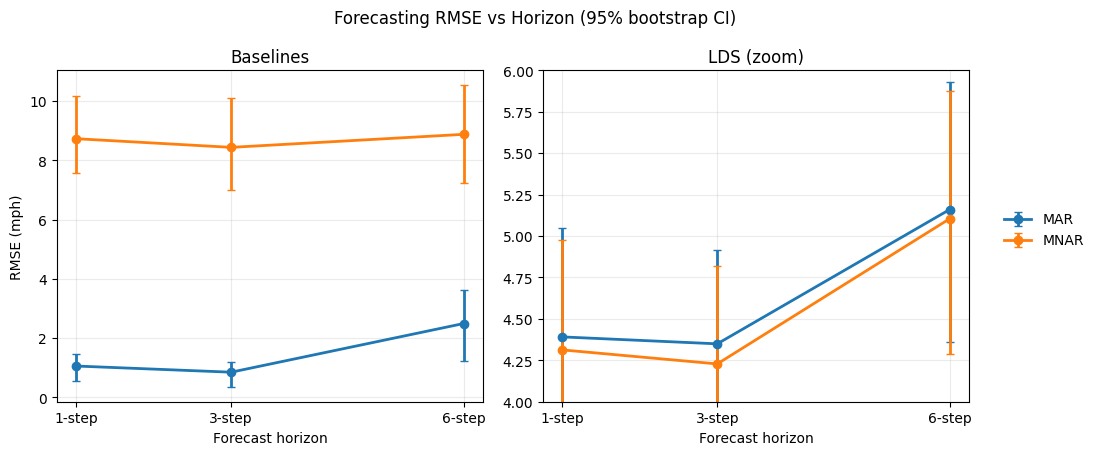

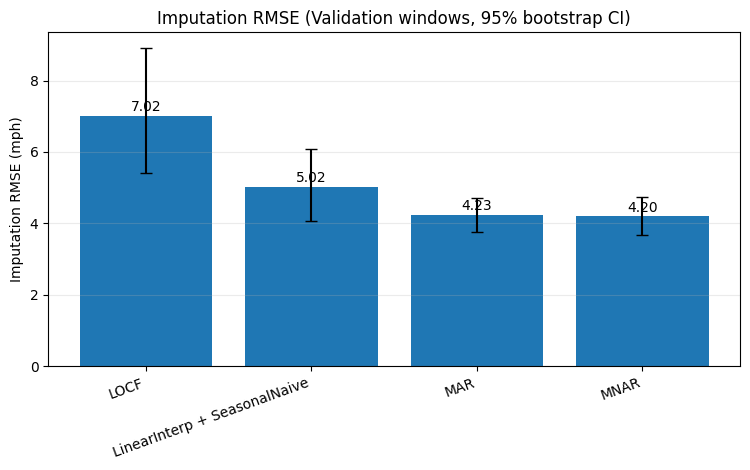

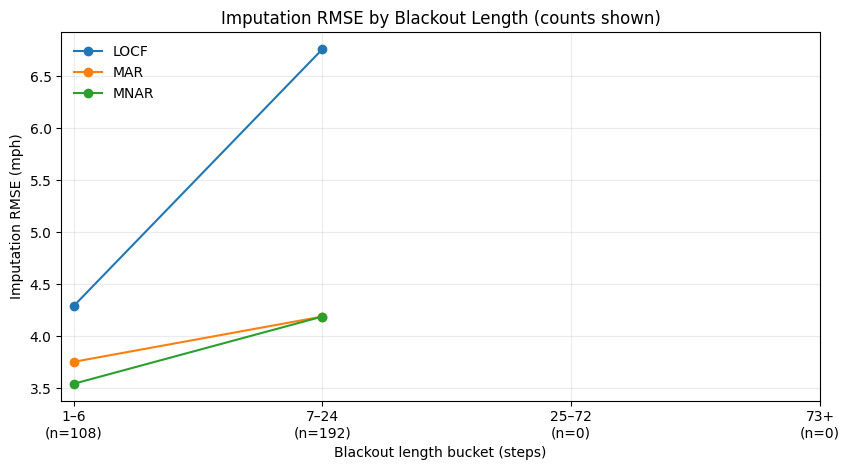

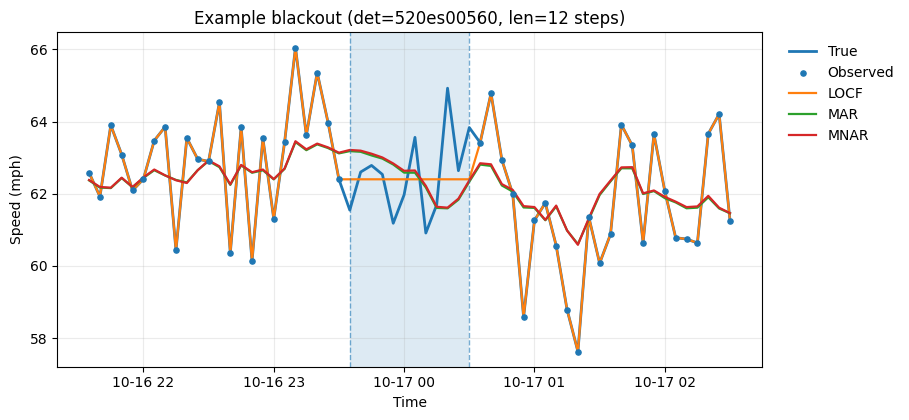

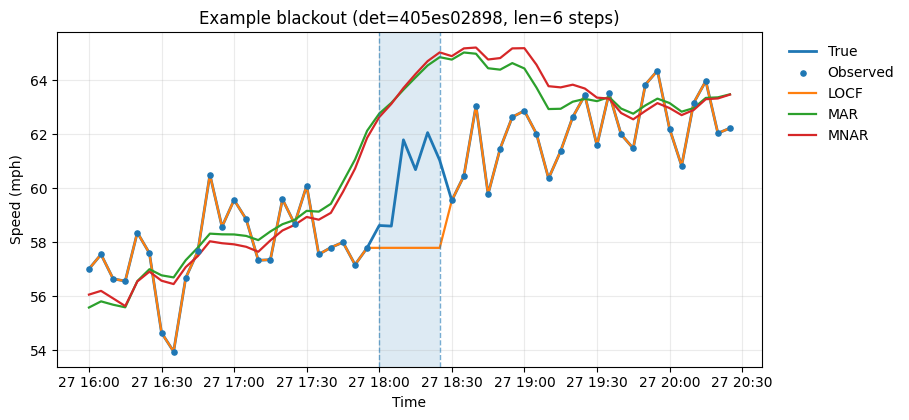

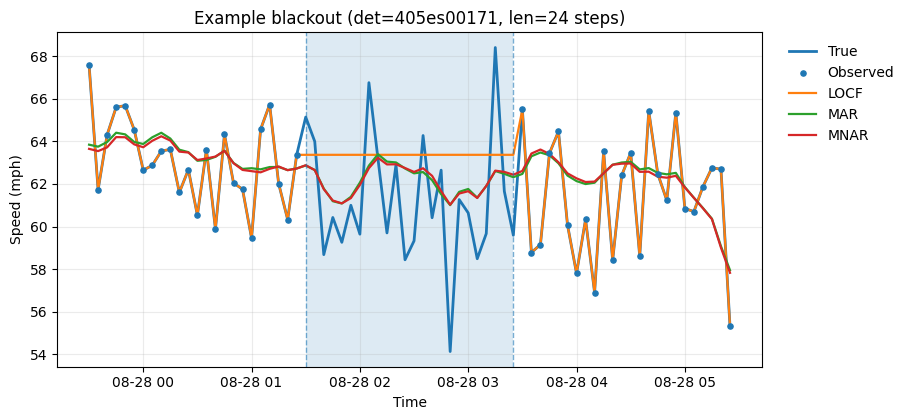

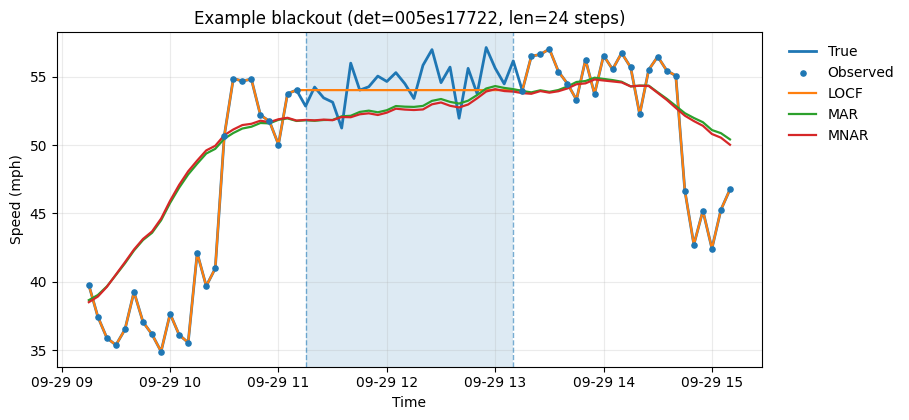


Saved figures to: c:\Users\Dell\Downloads\Modeling-Information-Blackouts-in-MNAR-Time-Series-main (2) (1)\Modeling-Information-Blackouts-in-MNAR-Time-Series-main\Modeling-Information-Blackouts-in-MNAR-Time-Series-main\figures


In [ ]:
# ============================================================
# 5) Publication plots (paper-ready, saved to ./figures)
# ============================================================

FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

def _savefig(name: str):
    for ext in ["png", "pdf"]:
        plt.savefig(os.path.join(FIG_DIR, f"{name}.{ext}"),
                    dpi=300, bbox_inches="tight")

# ------------------------------
# Bootstrap CI helpers
# ------------------------------
def _bootstrap_ci(values, B=500, seed=0, agg_fn=np.mean, alpha=0.05):
    """
    Nonparametric bootstrap CI for a scalar statistic agg_fn(values).
    Returns: (center, lo, hi)
    """
    v = np.asarray(values, float)
    v = v[np.isfinite(v)]
    if v.size == 0:
        return np.nan, np.nan, np.nan
    rs = np.random.default_rng(seed)
    stats = np.empty(B, dtype=float)
    n = v.size
    for b in range(B):
        samp = v[rs.integers(0, n, size=n)]
        stats[b] = float(agg_fn(samp))
    center = float(agg_fn(v))
    lo = float(np.quantile(stats, alpha / 2))
    hi = float(np.quantile(stats, 1 - alpha / 2))
    return center, lo, hi

def _bootstrap_rmse_from_se(se_list, B=500, seed=0, alpha=0.05):
    """
    Bootstrap RMSE from a list of squared errors.
    Returns: (rmse_center, rmse_lo, rmse_hi)
    """
    se = np.asarray(se_list, float)
    se = se[np.isfinite(se)]
    if se.size == 0:
        return np.nan, np.nan, np.nan
    def _rmse(x): return float(np.sqrt(np.mean(x)))
    return _bootstrap_ci(se, B=B, seed=seed, agg_fn=_rmse, alpha=alpha)

def _bootstrap_weighted_rmse_from_mse(mse_list, weights, B=500, seed=0, alpha=0.05):
    """
    Bootstrap weighted RMSE given per-window MSE and per-window weights (e.g., len_steps).
    Resamples windows with replacement and recomputes weighted mean MSE -> RMSE.
    Returns: (rmse_center, rmse_lo, rmse_hi)
    """
    mse = np.asarray(mse_list, float)
    w = np.asarray(weights, float)
    mask = np.isfinite(mse) & np.isfinite(w) & (w > 0)
    mse = mse[mask]; w = w[mask]
    if mse.size == 0:
        return np.nan, np.nan, np.nan
    rs = np.random.default_rng(seed)
    n = mse.size
    stats = np.empty(B, dtype=float)
    for b in range(B):
        idx = rs.integers(0, n, size=n)
        mm = mse[idx]; ww = w[idx]
        m_w = float(np.average(mm, weights=ww))
        stats[b] = float(np.sqrt(m_w))
    center = float(np.sqrt(np.average(mse, weights=w)))
    lo = float(np.quantile(stats, alpha / 2))
    hi = float(np.quantile(stats, 1 - alpha / 2))
    return center, lo, hi

def _collect_impute_window_mse(x_true, x_pred, meta, windows):
    """
    Returns:
      mse_list:  per-window MSE (over finite points)
      w_list:    per-window weights (len_steps)
    """
    mse_list, w_list = [], []
    for w in windows:
        s = np.where(meta["timestamps"] == w["blackout_start"])[0][0]
        e = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
        d = np.where(meta["detectors"] == w["detector_id"])[0][0]
        y_true = x_true[s:e+1, d]
        y_pred = x_pred[s:e+1, d]
        mask = np.isfinite(y_true) & np.isfinite(y_pred)
        if not mask.any():
            continue
        mse = sklearn.metrics.mean_squared_error(y_true[mask], y_pred[mask])
        mse_list.append(float(mse))
        w_list.append(int(w["len_steps"]))
    return mse_list, w_list

def _collect_forecast_window_se_model(model, mu_filt, Sigma_filt, x_true, meta, windows):
    """
    Returns dict horizon->list of squared errors for model forecasts.
    """
    out = {1: [], 3: [], 6: []}
    for w in windows:
        end_idx = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
        d = np.where(meta["detectors"] == w["detector_id"])[0][0]
        h = int(w["horizon_steps"])
        target_idx = end_idx + h
        if target_idx >= x_true.shape[0]:
            continue
        yt = x_true[target_idx, d]
        if not np.isfinite(yt):
            continue
        yhat_vec, _ = model.k_step_forecast(mu_filt, Sigma_filt, end_idx, k=h)
        yp = float(yhat_vec[d])
        if not np.isfinite(yp):
            continue
        out[h].append(float((yp - float(yt)) ** 2))
    return out

def _collect_forecast_window_se_baseline(forecast_fn, x_true, x_masked, meta, windows):
    """
    Returns dict horizon->list of squared errors for baseline forecasts.
    forecast_fn(x_masked, target_idx, detector_idx) -> scalar
    """
    out = {1: [], 3: [], 6: []}
    for w in windows:
        end_idx = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
        d = np.where(meta["detectors"] == w["detector_id"])[0][0]
        h = int(w["horizon_steps"])
        target_idx = end_idx + h
        if target_idx >= x_true.shape[0]:
            continue
        yt = x_true[target_idx, d]
        if not np.isfinite(yt):
            continue
        yp = float(forecast_fn(x_masked, target_idx, d))
        if not np.isfinite(yp):
            continue
        out[h].append(float((yp - float(yt)) ** 2))
    return out

        
 # ---------------- Baselines: Linear interp + Seasonal naive ----------------
metrics_lin_season = evaluate_impute_forecast_baseline(
    x_t_true=x_t,
    x_t_masked=x_t_train,
    meta=meta,
    impute_fn=linear_interp_impute_baseline,
    forecast_fn=seasonal_naive_forecast_baseline,
    label="LinearInterp (impute) + SeasonalNaive (forecast)",
)

# ============================================================
# A) Metrics summary table
# ============================================================
metrics_rows = [
    ("LOCF", baseline_locf_metrics),
    ("LinearInterp + SeasonalNaive", metrics_lin_season),
    ("MAR", metrics_mar),
    ("MNAR", metrics_mnar),
]

metrics_df = pd.DataFrame([
    {
        "method": name,
        "impute_rmse": md["impute_rmse"],
        "forecast_rmse_1": md["forecast_rmse_1"],
        "forecast_rmse_3": md["forecast_rmse_3"],
        "forecast_rmse_6": md["forecast_rmse_6"],
    }
    for name, md in metrics_rows
])

metrics_df.to_csv(os.path.join(FIG_DIR, "metrics_summary.csv"), index=False)
display(metrics_df)

# ============================================================
# B) Forecast RMSE vs horizon (two panels + 95% bootstrap CI)
# ============================================================
horizons = np.array([1, 3, 6])

# build SE lists for CI (same eval windows you used)
forecast_windows_val = (
    forecast_1_evaluation_windows_val
    + forecast_3_evaluation_windows_val
    + forecast_6_evaluation_windows_val
)

# Baselines: LOCF + SeasonalNaive
se_locf = _collect_forecast_window_se_baseline(
    forecast_fn=lambda xm, tidx, d: locf_forecast_baseline(xm, tidx, d),
    x_true=x_t, x_masked=x_t_train, meta=meta, windows=forecast_windows_val
)
se_season = _collect_forecast_window_se_baseline(
    forecast_fn=seasonal_naive_forecast_baseline,
    x_true=x_t, x_masked=x_t_train, meta=meta, windows=forecast_windows_val
)

# LDS models: MAR + MNAR
se_mar = _collect_forecast_window_se_model(
    model_mar, mu_filt_mar, Sigma_filt_mar, x_t, meta, forecast_windows_val
)
se_mnar = _collect_forecast_window_se_model(
    model_mnar, mu_filt_mnar, Sigma_filt_mnar, x_t, meta, forecast_windows_val
)

def _rmse_ci_curve(se_dict, seed=0, B=500):
    rmse = []
    lo = []
    hi = []
    for h in horizons:
        c, l, u = _bootstrap_rmse_from_se(se_dict[int(h)], B=B, seed=seed + int(h))
        rmse.append(c); lo.append(l); hi.append(u)
    rmse = np.asarray(rmse, float)
    lo = np.asarray(lo, float)
    hi = np.asarray(hi, float)
    yerr = np.vstack([rmse - lo, hi - rmse])
    return rmse, yerr

base_curves = [
    ("LOCF", se_locf),
    ("SeasonalNaive", se_season),
]
lds_curves = [
    ("MAR", se_mar),
    ("MNAR", se_mnar),
]

fig, axes = plt.subplots(1, 2, figsize=(10.8, 4.6), sharex=True)

# Panel 1: baselines
ax = axes[0]
for name, se_dict in base_curves:
    y, yerr = _rmse_ci_curve(se_dict, seed=42, B=500)
    ax.errorbar(horizons, y, yerr=yerr, marker="o", linewidth=2, capsize=3, label=name)
ax.set_xticks(horizons, [f"{h}-step" for h in horizons])
ax.set_xlabel("Forecast horizon")
ax.set_ylabel("RMSE (mph)")
ax.set_title("Baselines")
ax.grid(True, alpha=0.25)

# Panel 2: LDS (zoomed y-lims to avoid baseline domination)
ax = axes[1]
for name, se_dict in lds_curves:
    y, yerr = _rmse_ci_curve(se_dict, seed=42, B=500)
    ax.errorbar(horizons, y, yerr=yerr, marker="o", linewidth=2, capsize=3, label=name)
ax.set_xticks(horizons, [f"{h}-step" for h in horizons])
ax.set_xlabel("Forecast horizon")
ax.set_title("LDS (zoom)")
ax.grid(True, alpha=0.25)
ax.set_ylim(4.0, 6.0)  # adjust if needed

# Legend outside to avoid overlap
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc="center right", frameon=False, bbox_to_anchor=(1.02, 0.5))
fig.suptitle("Forecasting RMSE vs Horizon (95% bootstrap CI)")
plt.tight_layout(rect=[0, 0, 0.92, 1])
_savefig("forecast_rmse_by_horizon_panels_ci")
plt.show()

# ============================================================
# C) Imputation RMSE bar plot (value labels + 95% bootstrap CI)
# ============================================================
def fill_impute_predictions(x_t_masked, windows, meta, impute_fn):
    x_pred = x_t_masked.copy().astype(float)
    seen = set()
    for w in windows:
        key = (w["blackout_start"], w["blackout_end"], w["detector_id"])
        if key in seen:
            continue
        seen.add(key)
        s = np.where(meta["timestamps"] == w["blackout_start"])[0][0]
        e = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
        d = np.where(meta["detectors"] == w["detector_id"])[0][0]
        x_pred[s:e+1, d] = impute_fn(x_t_masked, s, e, d)
    return x_pred

order = ["LOCF", "LinearInterp + SeasonalNaive", "MAR", "MNAR"]

# Create full imputation predictions used for per-window MSE collection
# (LOCF already built; MAR/MNAR recon built; linear interp uses fill helper)
recon_mar_full, _  = model_mar.reconstruct_from_smoother(mu_smooth_mar,  Sigma_smooth_mar)
recon_mnar_full, _ = model_mnar.reconstruct_from_smoother(mu_smooth_mnar, Sigma_smooth_mnar)

x_locf_full = fill_impute_predictions(
    x_t_train, impute_evaluation_windows_val, meta, locf_impute_baseline
)
x_lin_full = fill_impute_predictions(
    x_t_train, impute_evaluation_windows_val, meta, linear_interp_impute_baseline
)

impute_pred_map = {
    "LOCF": x_locf_full,
    "LinearInterp + SeasonalNaive": x_lin_full,
    "MAR": recon_mar_full,
    "MNAR": recon_mnar_full,
}

impute_vals = []
impute_yerr = []
for i, name in enumerate(order):
    mse_list, w_list = _collect_impute_window_mse(x_t, impute_pred_map[name], meta, impute_evaluation_windows_val)
    c, lo, hi = _bootstrap_weighted_rmse_from_mse(mse_list, w_list, B=500, seed=42 + i)
    impute_vals.append(c)
    impute_yerr.append([c - lo, hi - c])
impute_vals = np.asarray(impute_vals, float)
impute_yerr = np.asarray(impute_yerr, float).T  # shape (2, n_bars)

plt.figure(figsize=(7.6, 4.8))
bars = plt.bar(order, impute_vals, yerr=impute_yerr, capsize=4)
plt.ylabel("Imputation RMSE (mph)")
plt.title("Imputation RMSE (Validation windows, 95% bootstrap CI)")
plt.xticks(rotation=20, ha="right")
plt.grid(True, axis="y", alpha=0.25)

# Value labels on bars
for b in bars:
    h = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, h + 0.05, f"{h:.2f}",
             ha="center", va="bottom", fontsize=10)

plt.tight_layout()
_savefig("impute_rmse_methods_ci_labels")
plt.show()

# ============================================================
# D) Imputation RMSE by blackout length bucket
#    (requires eval_impute_rmse_by_length helper)
# ============================================================
# Full reconstructions

(rmse_len_locf, n_len_locf) = eval_impute_rmse_by_length(x_t, x_locf_full, meta, impute_evaluation_windows_val)
(rmse_len_mar,  n_len_mar)  = eval_impute_rmse_by_length(x_t, recon_mar_full, meta, impute_evaluation_windows_val)
(rmse_len_mnar, n_len_mnar) = eval_impute_rmse_by_length(x_t, recon_mnar_full, meta, impute_evaluation_windows_val)

bucket_keys = ["1–6", "7–24", "25–72", "73+"]
xk = np.arange(len(bucket_keys))

# show counts (use MAR counts; should match across methods if windows identical)
bucket_labels = [f"{k}\n(n={n_len_mar.get(k,0)})" for k in bucket_keys]

plt.figure(figsize=(8.6, 4.8))
plt.plot(xk, [rmse_len_locf[k] for k in bucket_keys], marker="o", label="LOCF")
plt.plot(xk, [rmse_len_mar[k]  for k in bucket_keys], marker="o", label="MAR")
plt.plot(xk, [rmse_len_mnar[k] for k in bucket_keys], marker="o", label="MNAR")

# If buckets are empty, RMSE is NaN -> line breaks naturally; labels still show n=0
plt.xticks(xk, bucket_labels, rotation=0, ha="center")
plt.xlabel("Blackout length bucket (steps)")
plt.ylabel("Imputation RMSE (mph)")
plt.title("Imputation RMSE by Blackout Length (counts shown)")
plt.grid(True, alpha=0.25)
plt.legend(frameon=False, loc="upper left")
plt.tight_layout()
_savefig("impute_rmse_by_length_bucket_counts")
plt.show()

# ============================================================
# E) Qualitative example windows
# ============================================================
def plot_example_windows(n_examples=4, seed=42):
    rs = np.random.default_rng(seed)
    picks = rs.choice(len(impute_evaluation_windows_val),
                      size=min(n_examples, len(impute_evaluation_windows_val)),
                      replace=False)
    for j, idx in enumerate(picks, 1):
        w = impute_evaluation_windows_val[int(idx)]
        s = np.where(meta["timestamps"] == w["blackout_start"])[0][0]
        e = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
        d = np.where(meta["detectors"] == w["detector_id"])[0][0]
        pad = 24
        a = max(0, s - pad)
        b = min(x_t.shape[0], e + pad + 1)

        plt.figure(figsize=(9.2, 4.3))

        # True (full) series for reference
        plt.plot(meta["timestamps"][a:b], x_t[a:b, d], label="True", linewidth=2)

        # Observed markers from the *masked* panel (shows what's actually available)
        obs_mask_seg = np.isfinite(x_t_train[a:b, d])
        plt.scatter(
            meta["timestamps"][a:b][obs_mask_seg],
            x_t_train[a:b, d][obs_mask_seg],
            s=14,
            marker="o",
            label="Observed",
            zorder=3,
        )

        # Reconstructions / imputations
        plt.plot(meta["timestamps"][a:b], x_locf_full[a:b, d], label="LOCF", linewidth=1.6)
        plt.plot(meta["timestamps"][a:b], recon_mar_full[a:b, d], label="MAR", linewidth=1.6)
        plt.plot(meta["timestamps"][a:b], recon_mnar_full[a:b, d], label="MNAR", linewidth=1.6)

        # Blackout region + boundary markers
        plt.axvspan(meta["timestamps"][s], meta["timestamps"][e], alpha=0.15)
        plt.axvline(meta["timestamps"][s], linestyle="--", linewidth=1.0, alpha=0.6)
        plt.axvline(meta["timestamps"][e], linestyle="--", linewidth=1.0, alpha=0.6)
        plt.title(f"Example blackout (det={w['detector_id']}, len={w['len_steps']} steps)")
        plt.ylabel("Speed (mph)")
        plt.xlabel("Time")
        plt.grid(True, alpha=0.25)
        plt.legend(frameon=False, loc="upper left", bbox_to_anchor=(1.02, 1.0))
        plt.tight_layout()
        _savefig(f"example_window_{j}")
        plt.show()

plot_example_windows()
print(f"\nSaved figures to: {os.path.abspath(FIG_DIR)}")


In [ ]:
# ---------------- Baselines: Linear interp + Seasonal naive ----------------
metrics_lin_season = evaluate_impute_forecast_baseline(
    x_t_true=x_t,
    x_t_masked=x_t_train,
    meta=meta,
    impute_fn=linear_interp_impute_baseline,
    forecast_fn=seasonal_naive_forecast_baseline,
    label="LinearInterp (impute) + SeasonalNaive (forecast)",
)

metrics_spline_season = evaluate_impute_forecast_baseline(
    x_t_true=x_t,
    x_t_masked=x_t_train,
    meta=meta,
    impute_fn=spline_impute_baseline,
    forecast_fn=seasonal_naive_forecast_baseline,
    label="Spline (impute, fallback->linear) + SeasonalNaive (forecast)",
)

def _delta(a, b, key):
    return a[key] - b[key]

print("\n=== Summary deltas (lower is better) ===")
print("Dynamics win  (LOCF -> MAR)  impute_RMSE:", _delta(metrics_mar, baseline_locf_metrics, "impute_rmse"))
print("MNAR refine   (MAR  -> MNAR) impute_RMSE:", _delta(metrics_mnar, metrics_mar, "impute_rmse"))
print("MNAR refine   (MAR  -> MNAR) fcast_RMSE1:", _delta(metrics_mnar, metrics_mar, "forecast_rmse_1"))
print("MNAR refine   (MAR  -> MNAR) fcast_RMSE3:", _delta(metrics_mnar, metrics_mar, "forecast_rmse_3"))
print("MNAR refine   (MAR  -> MNAR) fcast_RMSE6:", _delta(metrics_mnar, metrics_mar, "forecast_rmse_6"))

In [36]:
# ============================================================
# 5) BRITS / GRU-D hook
# ============================================================
try:
    # ------------------------------------------------------------
    # GRU-D style imputer (torch-only baseline)
    # - Causal imputation (uses past only)
    # - Forecasting via free-run after blackout end (no peeking)
    # ------------------------------------------------------------
    class GRUDImputer(nn.Module):
        def __init__(self, D: int, hidden: int = 128):
            super().__init__()
            self.D = D
            self.hidden = hidden
            # Per-feature decay -> D outputs
            self.decay = nn.Linear(D, D)
            # Input uses [x_tilde, obs_mask]
            self.inp = nn.Linear(2 * D, hidden)
            self.cell = nn.GRUCell(hidden, hidden)
            self.out = nn.Linear(hidden, D)

        def forward(
            self,
            x_filled: torch.Tensor,   # (B,T,D) NaNs already replaced
            obs_mask: torch.Tensor,   # (B,T,D) 1 if observed else 0
            delta: torch.Tensor,      # (B,T,D) time since last obs (in steps)
            x_mean: torch.Tensor,     # (D,)
            h0: torch.Tensor | None = None,  # (B,H)
            last_x0: torch.Tensor | None = None,  # (B,D) initial last observed per feature
        ):
            B, T, D = x_filled.shape
            device = x_filled.device

            if h0 is None:
                h = torch.zeros(B, self.hidden, device=device)
            else:
                h = h0

            # last observed value per feature
            if last_x0 is None:
                last_x = x_mean[None, :].repeat(B, 1)  # (B,D)
            else:
                last_x = last_x0

            preds = []
            h_seq = []

            for t in range(T):
                x_t = x_filled[:, t, :]         # (B,D)
                m_t = obs_mask[:, t, :]         # (B,D)
                d_t = delta[:, t, :]            # (B,D)

                # gamma = exp(-relu(W d + b))  in (0,1]
                gamma = torch.exp(-torch.relu(self.decay(d_t)))

                # GRU-D input imputation
                x_hat = gamma * last_x + (1.0 - gamma) * x_mean[None, :]
                x_tilde = m_t * x_t + (1.0 - m_t) * x_hat

                # update last observed
                last_x = m_t * x_t + (1.0 - m_t) * last_x

                u = torch.tanh(self.inp(torch.cat([x_tilde, m_t], dim=-1)))  # (B,H)
                h = self.cell(u, h)                                          # (B,H)
                y = self.out(h)                                              # (B,D)

                preds.append(y)
                h_seq.append(h)

            preds = torch.stack(preds, dim=1)   # (B,T,D)
            h_seq = torch.stack(h_seq, dim=1)   # (B,T,H)
            return preds, h_seq


    def _compute_delta(obs_mask_np: np.ndarray) -> np.ndarray:
        """
        obs_mask_np: (T,D) with 1 if observed else 0
        returns delta in steps since last observation, (T,D)
        """
        T, D = obs_mask_np.shape
        delta = np.zeros((T, D), dtype=np.float32)
        last = np.zeros((D,), dtype=np.float32)
        for t in range(T):
            if t > 0:
                last += 1.0
            # where observed at time t -> reset to 0
            obs = obs_mask_np[t].astype(bool)
            last[obs] = 0.0
            delta[t] = last
        return delta


    # -----------------------------
    # Prepare tensors from your panel
    # -----------------------------
    # Expected existing vars in your notebook:
    #   x_t_train, m_t_train, x_t, m_t, meta
    # where m_t is 1=missing, 0=observed
    x_train = x_t_train.copy().astype(np.float32)
    obs_mask = ((m_t_train == 0) & np.isfinite(x_train)).astype(np.float32)  # (T,D) 1=observed
    delta = _compute_delta(obs_mask)                                         # (T,D)

    # Compute mean/std using observed values only
    x_train_nan0 = np.nan_to_num(x_train, nan=0.0)
    obs_cnt = obs_mask.sum(axis=0) + 1e-6
    x_mean = ((x_train_nan0 * obs_mask).sum(axis=0) / obs_cnt).astype(np.float32)
    x_var  = (((x_train_nan0 - x_mean[None, :]) ** 2) * obs_mask).sum(axis=0) / obs_cnt
    x_std  = np.sqrt(np.maximum(x_var, 1e-6)).astype(np.float32)

    # Normalize; for missing entries, fill with 0 (=mean after normalization)
    x_norm = (x_train_nan0 - x_mean[None, :]) / x_std[None, :]
    x_filled = (x_norm * obs_mask).astype(np.float32)  # missing -> 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    D = x_filled.shape[1]
    model_grud = GRUDImputer(D=D, hidden=128).to(device)
    opt = torch.optim.Adam(model_grud.parameters(), lr=1e-3)

    x_mean_t = torch.tensor(np.zeros_like(x_mean), device=device)  # mean in normalized space is 0

    # -----------------------------
    # Mini-batch training via random subsequences
    # -----------------------------
    T_total = x_filled.shape[0]
    seq_len = 288           # 1 day on 5-min grid
    batch_size = 16
    steps = 1500       

    rs = np.random.default_rng(0)

    def make_batch():
        starts = rs.integers(0, max(1, T_total - seq_len - 1), size=batch_size)
        xb = np.stack([x_filled[s:s+seq_len] for s in starts], axis=0)     # (B,L,D)
        mb = np.stack([obs_mask[s:s+seq_len] for s in starts], axis=0)     # (B,L,D)
        db = np.stack([delta[s:s+seq_len] for s in starts], axis=0)        # (B,L,D)
        return xb, mb, db

    model_grud.train()
    for step in range(1, steps + 1):
        xb, mb, db = make_batch()
        xb_t = torch.from_numpy(xb).to(device)
        mb_t = torch.from_numpy(mb).to(device)
        db_t = torch.from_numpy(db).to(device)

        pred, _ = model_grud(xb_t, mb_t, db_t, x_mean_t)

        # loss only where observed (mb_t == 1)
        diff2 = (pred - xb_t) ** 2
        loss = (diff2 * mb_t).sum() / (mb_t.sum() + 1e-6)

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_grud.parameters(), 1.0)
        opt.step()

        if step % 50 == 0:
            print(f"[GRU-D] step {step:4d}/{steps}  loss={float(loss):.5f}")

    # -----------------------------
    # One full forward pass to cache predictions + hidden states
    # -----------------------------
    model_grud.eval()
    with torch.no_grad():
        x_full = torch.from_numpy(x_filled[None, :, :]).to(device)     # (1,T,D) normalized
        m_full = torch.from_numpy(obs_mask[None, :, :]).to(device)     # (1,T,D)
        d_full = torch.from_numpy(delta[None, :, :]).to(device)        # (1,T,D)
        pred_full, h_full = model_grud(x_full, m_full, d_full, x_mean_t)
        pred_full = pred_full[0].cpu().numpy()                         # (T,D) normalized
        h_full = h_full[0].cpu().numpy()                               # (T,H)

    # De-normalize cached predictions back to mph for evaluation
    pred_full = (pred_full * x_std[None, :]) + x_mean[None, :]
    
    # Cache last observed value per feature at each timestep (for proper free-run)
    last_x_hist = np.zeros_like(x_train_nan0, dtype=np.float32)  # (T,D) in mph
    last = x_mean.copy()  # mph
    for t in range(x_filled.shape[0]):
        if t == 0:
            last = x_mean.copy()
        else:
            # update last where observed at time t
            obs = obs_mask[t].astype(bool)
            last[obs] = x_train_nan0[t, obs]  # mph
        last_x_hist[t] = last

    # -----------------------------
    # Forecast helper: free-run k steps after end_idx
    # -----------------------------
    def grud_forecast_k(end_idx: int, k: int) -> np.ndarray:
        """
        Returns predicted x at time end_idx + k, without using ground truth
        beyond end_idx (free-run with missing masks).
        """
        model_grud.eval()
        with torch.no_grad():
            # start hidden at end_idx
            h0 = torch.tensor(h_full[end_idx][None, :], device=device)  # (1,H)

            # Convert last observed mph -> normalized for GRU-D state init
            last_x0_mph = last_x_hist[end_idx][None, :]
            last_x0_norm = (last_x0_mph - x_mean[None, :]) / x_std[None, :]
            last_x0 = torch.tensor(last_x0_norm, device=device, dtype=torch.float32)  # (1,D)

            # build a tiny rollout of length k, with "all missing" inputs
            # delta should start from per-feature delta at end_idx and then increase
            xb = torch.zeros(1, k, D, device=device)  # normalized zeros (=mean)
            mb = torch.zeros(1, k, D, device=device)   # all missing
            delta0 = torch.tensor(delta[end_idx], device=device, dtype=torch.float32)  # (D,)
            step_vec = torch.arange(1, k + 1, device=device, dtype=torch.float32).view(k, 1)  # (k,1)
            db = (delta0.view(1, D) + step_vec).view(1, k, D)  # (1,k,D)

            pred_k, _ = model_grud(xb, mb, db, x_mean_t, h0=h0, last_x0=last_x0)
            y_norm = pred_k[0, -1].cpu().numpy()  # (D,) normalized
            return (y_norm * x_std) + x_mean       # (D,) mph

    # -----------------------------
    # Evaluate on the SAME windows using your existing evaluator
    # -----------------------------
    def grud_impute_fn(x_t_masked_unused, start_idx, end_idx, detector_idx):
        # causal predictions from pred_full on the masked training panel
        return pred_full[start_idx:end_idx+1, detector_idx].astype(float)

    # Better: custom forecast evaluation that knows end_idx + horizon (no leakage)
    def evaluate_grud_forecast_only(label="GRU-D (free-run forecast)"):
        y1t, y1p, y3t, y3p, y6t, y6p = [], [], [], [], [], []
        forecast_windows = (
            forecast_1_evaluation_windows_val
            + forecast_3_evaluation_windows_val
            + forecast_6_evaluation_windows_val
        )
        for w in forecast_windows:
            end_idx = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
            d = np.where(meta["detectors"] == w["detector_id"])[0][0]
            h = int(w["horizon_steps"])
            target_idx = end_idx + h
            if target_idx >= x_t.shape[0]:
                continue
            yt = float(x_t[target_idx, d])
            if not np.isfinite(yt):
                continue
            yp = float(grud_forecast_k(end_idx=end_idx, k=h)[d])
            if not np.isfinite(yp):
                continue
            if h == 1:
                y1t.append(yt); y1p.append(yp)
            elif h == 3:
                y3t.append(yt); y3p.append(yp)
            elif h == 6:
                y6t.append(yt); y6p.append(yp)

        import sklearn.metrics
        def _pack(y_pred, y_true, h):
            mae = sklearn.metrics.mean_absolute_error(y_true, y_pred)
            mse = sklearn.metrics.mean_squared_error(y_true, y_pred)
            rmse = float(np.sqrt(mse))
            print(f"{h}-step MAE : {mae}")
            print(f"{h}-step MSE : {mse}")
            print(f"{h}-step RMSE: {rmse}")

        print(f"\n[{label}] Forecasting performance (free-run):")
        print("-----------------------------------")
        _pack(y1p, y1t, 1)
        print("\n-----------------------------------")
        _pack(y3p, y3t, 3)
        print("\n-----------------------------------")
        _pack(y6p, y6t, 6)


    # Use your baseline evaluator for imputation (forecasting handled by custom function above)
    metrics_grud_impute = evaluate_impute_forecast_baseline(
        x_t_true=x_t,
        x_t_masked=x_t_train,
        meta=meta,
        impute_fn=grud_impute_fn,
        forecast_fn=seasonal_naive_forecast_baseline,  # keep a sane baseline here
        label="GRU-D (impute via torch) + SeasonalNaive (forecast)",
    )
    evaluate_grud_forecast_only(label="GRU-D (free-run forecast)")

    print("\n[GRU-D] Done.")
except Exception:
    print("\n[Optional] torch not available; skipping BRITS/GRU-D baseline hook.")

[GRU-D] step   50/1500  loss=0.29612
[GRU-D] step  100/1500  loss=0.23050
[GRU-D] step  150/1500  loss=0.22927
[GRU-D] step  200/1500  loss=0.17820
[GRU-D] step  250/1500  loss=0.15624
[GRU-D] step  300/1500  loss=0.12671
[GRU-D] step  350/1500  loss=0.12320
[GRU-D] step  400/1500  loss=0.14164
[GRU-D] step  450/1500  loss=0.11013
[GRU-D] step  500/1500  loss=0.08747
[GRU-D] step  550/1500  loss=0.07875
[GRU-D] step  600/1500  loss=0.07908
[GRU-D] step  650/1500  loss=0.06550
[GRU-D] step  700/1500  loss=0.06265
[GRU-D] step  750/1500  loss=0.06651
[GRU-D] step  800/1500  loss=0.05160
[GRU-D] step  850/1500  loss=0.05449
[GRU-D] step  900/1500  loss=0.05459
[GRU-D] step  950/1500  loss=0.04249
[GRU-D] step 1000/1500  loss=0.04509
[GRU-D] step 1050/1500  loss=0.04243
[GRU-D] step 1100/1500  loss=0.04492
[GRU-D] step 1150/1500  loss=0.03432
[GRU-D] step 1200/1500  loss=0.04268
[GRU-D] step 1250/1500  loss=0.04315
[GRU-D] step 1300/1500  loss=0.03742
[GRU-D] step 1350/1500  loss=0.03803
[

In [40]:
import sklearn.metrics

def evaluate_grud_impute_forecast(
    x_t_true,
    x_t_masked,          # (T,D) masked panel used to compute obs_mask/delta etc.
    meta,
    impute_windows,
    forecast_windows,
    pred_full,           # (T,D) GRU-D one-pass causal preds on masked panel
    grud_forecast_k_fn,  # function: (end_idx, k) -> (D,)
    label="GRU-D",
):
    # ---------------- Imputation ----------------
    impute_mae_list = []
    impute_mse_list = []

    for w in impute_windows:
        if w["test_type"] != "impute":
            continue
        s = np.where(meta["timestamps"] == w["blackout_start"])[0][0]
        e = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
        d = np.where(meta["detectors"] == w["detector_id"])[0][0]

        y_true = x_t_true[s:e+1, d].astype(float)
        y_pred = pred_full[s:e+1, d].astype(float)  # causal preds from masked pass

        mask = np.isfinite(y_true) & np.isfinite(y_pred)
        if not mask.any():
            continue

        mae = sklearn.metrics.mean_absolute_error(y_true[mask], y_pred[mask])
        mse = sklearn.metrics.mean_squared_error(y_true[mask], y_pred[mask])

        impute_mae_list.append([float(mae), int(w["len_steps"])])
        impute_mse_list.append([float(mse), int(w["len_steps"])])

    final_impute_mae = float(np.average([a for a,_ in impute_mae_list], weights=[w for _,w in impute_mae_list]))
    final_impute_mse = float(np.average([a for a,_ in impute_mse_list], weights=[w for _,w in impute_mse_list]))
    final_impute_rmse = float(np.sqrt(final_impute_mse))

    print(f"\n[{label}] Imputation performance:")
    print("  MAE :", final_impute_mae)
    print("  MSE :", final_impute_mse)
    print("  RMSE:", final_impute_rmse)

    # ---------------- Forecasting (free-run) ----------------
    y1t, y1p, y3t, y3p, y6t, y6p = [], [], [], [], [], []
    forecast_se = {1: [], 3: [], 6: []}

    for w in forecast_windows:
        if w["test_type"] != "forecast":
            continue

        end_idx = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
        d = np.where(meta["detectors"] == w["detector_id"])[0][0]
        h = int(w["horizon_steps"])
        target_idx = end_idx + h
        if target_idx >= x_t_true.shape[0]:
            continue

        yt = float(x_t_true[target_idx, d])
        if not np.isfinite(yt):
            continue

        yhat_vec = grud_forecast_k_fn(end_idx=end_idx, k=h)  # (D,)
        yp = float(yhat_vec[d])
        if not np.isfinite(yp):
            continue

        # Store squared error for bootstrap CI
        if h in forecast_se:
            forecast_se[h].append(float((yp - yt) ** 2))

        if h == 1:
            y1t.append(yt); y1p.append(yp)
        elif h == 3:
            y3t.append(yt); y3p.append(yp)
        elif h == 6:
            y6t.append(yt); y6p.append(yp)

    def _pack(y_pred, y_true, h):
        mae = sklearn.metrics.mean_absolute_error(y_true, y_pred)
        mse = sklearn.metrics.mean_squared_error(y_true, y_pred)
        rmse = float(np.sqrt(mse))
        print(f"{h}-step MAE :", mae)
        print(f"{h}-step MSE :", mse)
        print(f"{h}-step RMSE:", rmse)
        return float(mae), float(mse), float(rmse)

    print(f"\n[{label}] Forecasting performance:")
    print("-----------------------------------")
    mae1, mse1, rmse1 = _pack(y1p, y1t, 1)
    print("\n-----------------------------------")
    mae3, mse3, rmse3 = _pack(y3p, y3t, 3)
    print("\n-----------------------------------")
    mae6, mse6, rmse6 = _pack(y6p, y6t, 6)

    return {
        "impute_mae": final_impute_mae,
        "impute_mse": final_impute_mse,
        "impute_rmse": final_impute_rmse,
        "forecast_mae_1": mae1, "forecast_mse_1": mse1, "forecast_rmse_1": rmse1,
        "forecast_mae_3": mae3, "forecast_mse_3": mse3, "forecast_rmse_3": rmse3,
        "forecast_mae_6": mae6, "forecast_mse_6": mse6, "forecast_rmse_6": rmse6,
        "forecast_se": forecast_se,
    }

_grud_cache = {}
def grud_forecast_k_cached(end_idx: int, k: int) -> np.ndarray:
    """
    Cache GRU-D free-run forecasts per (end_idx, horizon) so CI/plots don't re-rollout repeatedly.
    Requires your existing grud_forecast_k(end_idx=..., k=...) -> (D,) to be defined elsewhere.
    """
    key = (int(end_idx), int(k))
    if key not in _grud_cache:
        _grud_cache[key] = grud_forecast_k(end_idx=end_idx, k=k)
    return _grud_cache[key]

def _collect_forecast_window_se_locf(x_true, x_masked, meta, windows):
    """
    LOCF forecast SE collector (NO leakage).
    IMPORTANT: locf_forecast_baseline(x_t_masked, end_idx, detector_idx) expects end_idx,
    not target_idx. Passing target_idx leaks because x_t_train[target_idx] isn't masked.
    """
    out = {1: [], 3: [], 6: []}
    for w in windows:
        end_idx = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
        d = np.where(meta["detectors"] == w["detector_id"])[0][0]
        h = int(w["horizon_steps"])
        target_idx = end_idx + h
        if target_idx >= x_true.shape[0]:
            continue

        yt = x_true[target_idx, d]
        if not np.isfinite(yt):
            continue

        # IMPORTANT: LOCF uses end_idx (end of blackout), not target_idx
        yp = float(locf_forecast_baseline(x_masked, end_idx, d))
        if not np.isfinite(yp):
            continue

        out[h].append(float((yp - float(yt)) ** 2))
    return out

def _collect_forecast_window_se_grud(grud_forecast_k_fn, x_true, meta, windows):
    """
    GRU-D forecast SE collector using a cached free-run forecaster.
      grud_forecast_k_fn(end_idx, k) -> (D,) vector of forecasts at horizon k
    """
    out = {1: [], 3: [], 6: []}
    for w in windows:
        end_idx = np.where(meta["timestamps"] == w["blackout_end"])[0][0]
        d = np.where(meta["detectors"] == w["detector_id"])[0][0]
        h = int(w["horizon_steps"])
        target_idx = end_idx + h
        if target_idx >= x_true.shape[0]:
            continue
        yt = x_true[target_idx, d]
        if not np.isfinite(yt):
            continue
        yhat_vec = grud_forecast_k_fn(end_idx=end_idx, k=h)
        yp = float(yhat_vec[d])
        if not np.isfinite(yp):
            continue
        out[h].append(float((yp - float(yt)) ** 2))
    return out

In [41]:
# ============================================================
# 6) Robustness: bootstrap CI table (same fitted models)
# ============================================================
# (i) Bootstrap metrics directly from per-window error lists
def summarize_with_ci():
    # Imputation weighted RMSE CI
    rows = []
    for name in order:
        mse_list, w_list = _collect_impute_window_mse(x_t, impute_pred_map[name], meta, impute_evaluation_windows_val)
        c, lo, hi = _bootstrap_weighted_rmse_from_mse(mse_list, w_list, B=1000, seed=123)
        row = {"method": name, "impute_rmse": c, "impute_rmse_ci_lo": lo, "impute_rmse_ci_hi": hi}
        rows.append(row)

    # Forecast RMSE CI (1/3/6)
    forecast_windows_val = (
        forecast_1_evaluation_windows_val
        + forecast_3_evaluation_windows_val
        + forecast_6_evaluation_windows_val
    )
    se_locf_local = _collect_forecast_window_se_locf(
        x_true=x_t, x_masked=x_t_train, meta=meta, windows=forecast_windows_val
    )
    se_season_local = _collect_forecast_window_se_baseline(
        forecast_fn=seasonal_naive_forecast_baseline,
        x_true=x_t, x_masked=x_t_train, meta=meta, windows=forecast_windows_val
    )
    se_mar_local = _collect_forecast_window_se_model(
        model_mar, mu_filt_mar, Sigma_filt_mar, x_t, meta, forecast_windows_val
    )
    se_mnar_local = _collect_forecast_window_se_model(
        model_mnar, mu_filt_mnar, Sigma_filt_mnar, x_t, meta, forecast_windows_val
    )
    se_map = {
        "LOCF": se_locf_local,
        "SeasonalNaive": se_season_local,
        "MAR": se_mar_local,
        "MNAR": se_mnar_local,
        "GRU-D": se_grud if "se_grud" in globals() else {1: [], 3: [], 6: []},
    }

    for h in [1, 3, 6]:
        if len(se_locf_local[h]) > 0:
            print(f"[sanity] LOCF horizon={h} RMSE_from_SE={np.sqrt(np.mean(se_locf_local[h])):.3f}  (n={len(se_locf_local[h])})")
 
    for r in rows:
        name = r["method"]
        se_dict = se_map["SeasonalNaive"] if name == "LinearInterp + SeasonalNaive" else se_map[name]
        for h in [1, 3, 6]:
            c, lo, hi = _bootstrap_rmse_from_se(se_dict[h], B=1000, seed=1000 + 97*h + hash(name) % 10_000)
            r[f"forecast_rmse_{h}"] = c
            r[f"forecast_rmse_{h}_ci_lo"] = lo
            r[f"forecast_rmse_{h}_ci_hi"] = hi

    df = pd.DataFrame(rows)
    display(df)
    df.to_csv(os.path.join(FIG_DIR, "metrics_with_bootstrap_ci.csv"), index=False)
    print("Saved:", os.path.join(FIG_DIR, "metrics_with_bootstrap_ci.csv"))

forecast_evaluation_windows_val = (
    forecast_1_evaluation_windows_val
    + forecast_3_evaluation_windows_val
    + forecast_6_evaluation_windows_val
)

metrics_grud = evaluate_grud_impute_forecast(
    x_t_true=x_t,
    x_t_masked=x_t_train,
    meta=meta,
    impute_windows=impute_evaluation_windows_val,
    forecast_windows=forecast_evaluation_windows_val,
    pred_full=pred_full,
    grud_forecast_k_fn=grud_forecast_k_cached,
    label="GRU-D",
)
se_grud = metrics_grud["forecast_se"]

summarize_with_ci()


[GRU-D] Imputation performance:
  MAE : 3.406385799673628
  MSE : 27.58170240358842
  RMSE: 5.251828481927834

[GRU-D] Forecasting performance:
-----------------------------------
1-step MAE : 4.227342399509787
1-step MSE : 44.08300780648585
1-step RMSE: 6.639503581329394

-----------------------------------
3-step MAE : 5.025647269113789
3-step MSE : 67.9185774516097
3-step RMSE: 8.241272805314098

-----------------------------------
6-step MAE : 5.531505289849097
6-step MSE : 79.91943419033606
6-step RMSE: 8.939767009846289
[sanity] LOCF horizon=1 RMSE_from_SE=7.860  (n=300)
[sanity] LOCF horizon=3 RMSE_from_SE=8.465  (n=300)
[sanity] LOCF horizon=6 RMSE_from_SE=8.942  (n=300)


,method,impute_rmse,impute_rmse_ci_lo,impute_rmse_ci_hi,forecast_rmse_1,forecast_rmse_1_ci_lo,forecast_rmse_1_ci_hi,forecast_rmse_3,forecast_rmse_3_ci_lo,forecast_rmse_3_ci_hi,forecast_rmse_6,forecast_rmse_6_ci_lo,forecast_rmse_6_ci_hi
0,LOCF,7.021057,5.274564,8.979957,7.860342,6.224674,9.606468,8.465183,6.584359,10.491009,8.941693,6.976088,10.879578
1,LinearInterp + SeasonalNaive,5.024416,4.058139,6.052568,8.733867,7.406915,10.067641,8.441537,6.832504,10.058236,8.881090,7.217547,10.610704
2,MAR,4.228815,3.761474,4.714108,4.391176,3.814267,5.071481,4.349354,3.769646,5.026279,5.159922,4.358516,5.943814
3,MNAR,4.195356,3.697326,4.733781,4.312736,3.748007,4.961545,4.228140,3.620566,4.858031,5.104356,4.321551,5.886977


Saved: figures\metrics_with_bootstrap_ci.csv


In [28]:

# ==========================================================
# 7) Multi-seed robustness (re-train 3–5 seeds)
# ==========================================================

SEEDS = [0, 1, 2, 3, 4]
seed_results = []
for s in SEEDS:
    # (A) re-sample windows with different seed (keeps month stratification)
    random.seed(s); np.random.seed(s)
    impute_evaluation_windows_val_s = stratified_month_sampling(impute_windows_pool, n_per_month=25, ts_key="blackout_start")
    val_ids_ordered_s = [w["window_id"] for w in impute_evaluation_windows_val_s]
    forecast_1_val_s = [forecast_1_by_id[wid] for wid in val_ids_ordered_s]
    forecast_3_val_s = [forecast_3_by_id[wid] for wid in val_ids_ordered_s]
    forecast_6_val_s = [forecast_6_by_id[wid] for wid in val_ids_ordered_s]
    evaluation_windows_val_s = forecast_1_val_s + forecast_3_val_s + forecast_6_val_s + impute_evaluation_windows_val_s

    # (B) re-mask train panel for this seed
    x_t_train_s, m_t_train_s, a_t_train_s = mask_evaluation_windows(x_t, m_t, evaluation_windows_val_s, meta)

    # (C) re-train MAR then MNAR (you can reduce num_iters for speed)
    mar_params_s = mnar_blackout_lds.MNARParams.init_random(K=latent_dim, D=D, seed=s)
    model_mar_s = mnar_blackout_lds.MNARBlackoutLDS(mar_params_s, use_missingness_obs=False)
    model_mar_s.em_train(x_t_train_s, m_t_train_s, num_iters=10, update_phi=False,
                         phi_steps=0, phi_lr=0.0, verbose=False, convergence_tol=1e-3,
                         use_missingness_obs=False)

    mnar_params_s = copy.deepcopy(model_mar_s.params)
    if hasattr(mnar_params_s, "phi") and (mnar_params_s.phi is not None): mnar_params_s.phi[:] = 0.0
    if hasattr(mnar_params_s, "phi_time") and (mnar_params_s.phi_time is not None) and (mnar_params_s.phi_time.size > 0): mnar_params_s.phi_time[:] = 0.0
    if hasattr(mnar_params_s, "phi_det") and (mnar_params_s.phi_det is not None) and (mnar_params_s.phi_det.size > 0): mnar_params_s.phi_det[:] = 0.0
    if hasattr(mnar_params_s, "bias_m") and (mnar_params_s.bias_m is not None): mnar_params_s.bias_m[:] = 0.0

    model_mnar_s = mnar_blackout_lds.MNARBlackoutLDS(mnar_params_s, use_missingness_obs=True, missingness_var_mode="moment")
    model_mnar_s.em_train(x_t_train_s, m_t_train_s, num_iters=10, update_phi=True, phi_steps=2, phi_lr=1e-4,
                          verbose=False, convergence_tol=1e-3, use_missingness_obs=True,
                          init_missingness_bias=True, init_phi_if_zero=True, init_phi_noise=1e-3, init_seed=s)

    # (D) Evaluate on THIS seed’s windows
    ekf_mar_s = model_mar_s.ekf_forward(x_t_train_s, m_t_train_s)
    sm_mar_s  = model_mar_s.rts_smoother(ekf_mar_s)

    ekf_mnar_s = model_mnar_s.ekf_forward(
        x_t_train_s, m_t_train_s,
        a_t=a_t_train_s,
        X_time=X_time,
        detector_features=detector_features,
    )
    sm_mnar_s  = model_mnar_s.rts_smoother(ekf_mnar_s)

    forecast_windows_s = forecast_1_val_s + forecast_3_val_s + forecast_6_val_s

    metrics_mar_s = evaluate_impute_forecast_model(
        model=model_mar_s,
        mu_smooth=sm_mar_s["mu_smooth"],
        Sigma_smooth=sm_mar_s["Sigma_smooth"],
        mu_filt=ekf_mar_s["mu_filt"],
        Sigma_filt=ekf_mar_s["Sigma_filt"],
        x_t=x_t,
        meta=meta,
        label=f"MAR seed={s}",
        impute_windows=impute_evaluation_windows_val_s,
        forecast_windows=forecast_windows_s,
    )

    metrics_mnar_s = evaluate_impute_forecast_model(
        model=model_mnar_s,
        mu_smooth=sm_mnar_s["mu_smooth"],
        Sigma_smooth=sm_mnar_s["Sigma_smooth"],
        mu_filt=ekf_mnar_s["mu_filt"],
        Sigma_filt=ekf_mnar_s["Sigma_filt"],
        x_t=x_t,
        meta=meta,
        label=f"MNAR seed={s}",
        impute_windows=impute_evaluation_windows_val_s,
        forecast_windows=forecast_windows_s,
    )

    seed_results.append({
        "seed": s,
        "MAR_impute_rmse": metrics_mar_s["impute_rmse"],
        "MNAR_impute_rmse": metrics_mnar_s["impute_rmse"],
        "MAR_fcast_rmse_1": metrics_mar_s["forecast_rmse_1"],
        "MNAR_fcast_rmse_1": metrics_mnar_s["forecast_rmse_1"],
        "MAR_fcast_rmse_3": metrics_mar_s["forecast_rmse_3"],
        "MNAR_fcast_rmse_3": metrics_mnar_s["forecast_rmse_3"],
        "MAR_fcast_rmse_6": metrics_mar_s["forecast_rmse_6"],
        "MNAR_fcast_rmse_6": metrics_mnar_s["forecast_rmse_6"],
    })
    
print("Multi-seed robustness skeleton ready.")

df = pd.DataFrame(seed_results)
print(df.describe().T[["mean","std","min","max"]])
print("\nDelta (MNAR - MAR) mean:")
for k in ["impute_rmse","fcast_rmse_1","fcast_rmse_3","fcast_rmse_6"]:
    print(k, (df[f"MNAR_{k}"] - df[f"MAR_{k}"]).mean())


[MAR seed=0] Imputation performance:
  MAE : 2.9236246004018556
  MSE : 19.399535806820026
  RMSE: 4.4044904139775385

[MAR seed=0] Forecasting performance:
-----------------------------------
1-step MAE : 3.192487120552901
1-step MSE : 21.732031306110336
1-step RMSE: 4.661762682302729

-----------------------------------
3-step MAE : 3.069976020556438
3-step MSE : 20.08668583266784
3-step RMSE: 4.481817246683296

-----------------------------------
6-step MAE : 3.068341146078558
6-step MSE : 19.453178221374728
6-step RMSE: 4.410575724480278

[MNAR seed=0] Imputation performance:
  MAE : 2.878459005987187
  MSE : 18.848388522724488
  RMSE: 4.341473082114467

[MNAR seed=0] Forecasting performance:
-----------------------------------
1-step MAE : 3.1681564193387164
1-step MSE : 21.24242415589535
1-step RMSE: 4.608950439730867

-----------------------------------
3-step MAE : 3.0516023094711233
3-step MSE : 19.964209222207906
3-step RMSE: 4.468132632566753

------------------------------